# Planar Flows Example in Pytorch

Goal is to learn more about PyTorch implementation of NFs via this 
- blog post https://vishakh.me/posts/normalizing_flows/ which implements planar flows from this paper https://arxiv.org/pdf/1505.05770.pdf in PyTorch
- and uses this corresponding code: https://github.com/VishakhG/normalizing-flows 

In [1]:
from matplotlib import pyplot as plt 
import seaborn as sns 

from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
import sys, copy
sys.path.append('./src')
sys.path.append('./ppo_code')

from src.densities import pot_1 
from src.utils import plot_pot_func
from src.normalizing_flows import * 
from src.utils import random_normal_samples

from ppo_code.normalizing_flows import random_normal_samples as prandom_normal_samples
from ppo_code.plotting_utils import plot_2D_potential
from ppo_code.normalizing_flows import NormalizingFlow as ppoNormalizingFlow


## Potential 1

In [6]:
target_density = pot_1 

### compare gopis and our potential plots: 

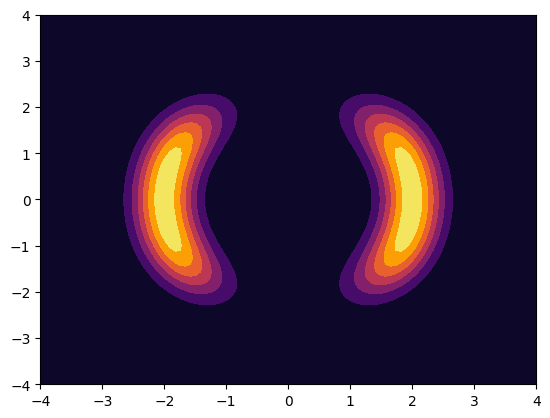

In [7]:
# gopi plots:
plot_pot_func(target_density)

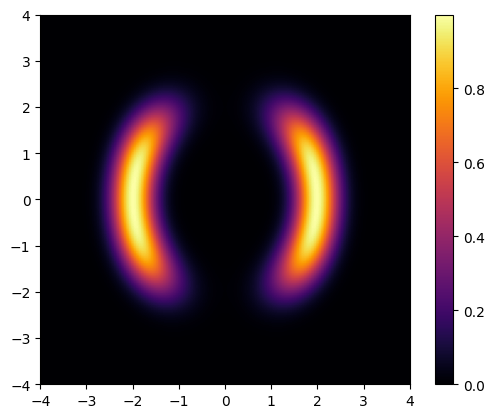

In [8]:
# ppo plots: 
plot_2D_potential(target_density )

### Compare gopi and our nf models

In [11]:
## gopi's model:
model = NormalizingFlow(2, n_flows=2)
for k,v in model.state_dict().items(): 
    print (k,v)

flows.0.u tensor([[-0.0068,  0.0055]])
flows.0.w tensor([[ 0.0076, -0.0095]])
flows.0.b tensor([-0.0089])
flows.1.u tensor([[0.0023, 0.0003]])
flows.1.w tensor([[-0.0049,  0.0093]])
flows.1.b tensor([-0.0075])


In [12]:
# ppo_model
ppomodel = ppoNormalizingFlow(2, n_flows=2)
for k,v in ppomodel.state_dict().items(): 
    print (k,v)

flows.0.u tensor([[-0.0054, -0.0084]])
flows.0.w tensor([[-0.0014, -0.0054]])
flows.0.b tensor([-0.0022])
flows.1.u tensor([[0.0096, 0.0055]])
flows.1.w tensor([[-0.0094, -0.0034]])
flows.1.b tensor([0.0067])


In [13]:
# set ppoNF params to those of the gopi NF
ppomodel.load_state_dict( copy.copy(model.state_dict() ) )
for k,v in ppomodel.state_dict().items(): 
    print (k,v)

flows.0.u tensor([[-0.0068,  0.0055]])
flows.0.w tensor([[ 0.0076, -0.0095]])
flows.0.b tensor([-0.0089])
flows.1.u tensor([[0.0023, 0.0003]])
flows.1.w tensor([[-0.0049,  0.0093]])
flows.1.b tensor([-0.0075])


In [16]:
samples = random_normal_samples(10, dim = 2)

z1, j1 = model(samples ) # (output and jacobian)
z2, j2 = ppomodel(samples) 
print(z1 == z2)
print(j1 == j2)

tensor([[True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True]])
tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])


### Train and compare results on potential 1

In [20]:
# hyperparameters: 
n_flows = 16
batch_size = 100 
learning_rate = .001 
epochs = 15000

momentum = .9

----Plotting Gopi before----
----Plotting training----
Iteration 0
Loss 5.6040849685668945
Iteration 100
Loss 1.405215859413147
Iteration 200
Loss 1.2323273420333862
Iteration 300
Loss 1.6440383195877075
Iteration 400
Loss 1.45098876953125
Iteration 500
Loss 1.0730363130569458
Iteration 600
Loss 0.9385222792625427
Iteration 700
Loss 1.3437494039535522
Iteration 800
Loss 0.9271829128265381
Iteration 900
Loss 1.1376134157180786
Iteration 1000
Loss 0.9528766870498657
Iteration 1100
Loss 0.9596710205078125
Iteration 1200
Loss 0.7910022139549255
Iteration 1300
Loss 0.9563127756118774
Iteration 1400
Loss 1.0048179626464844
Iteration 1500
Loss 0.8687456250190735
Iteration 1600
Loss 1.050511121749878
Iteration 1700
Loss 1.1934655904769897
Iteration 1800
Loss 1.093179702758789
Iteration 1900
Loss 1.0814244747161865
Iteration 2000
Loss 1.3296695947647095
Iteration 2100
Loss 0.9282851815223694
Iteration 2200
Loss 1.1625964641571045
Iteration 2300
Loss 1.0125032663345337
Iteration 2400
Loss 1.0742

Text(0.5, 1.0, 'Samples')

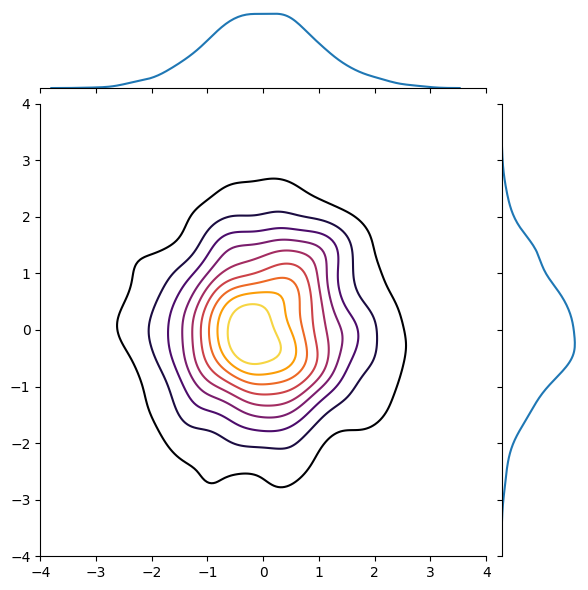

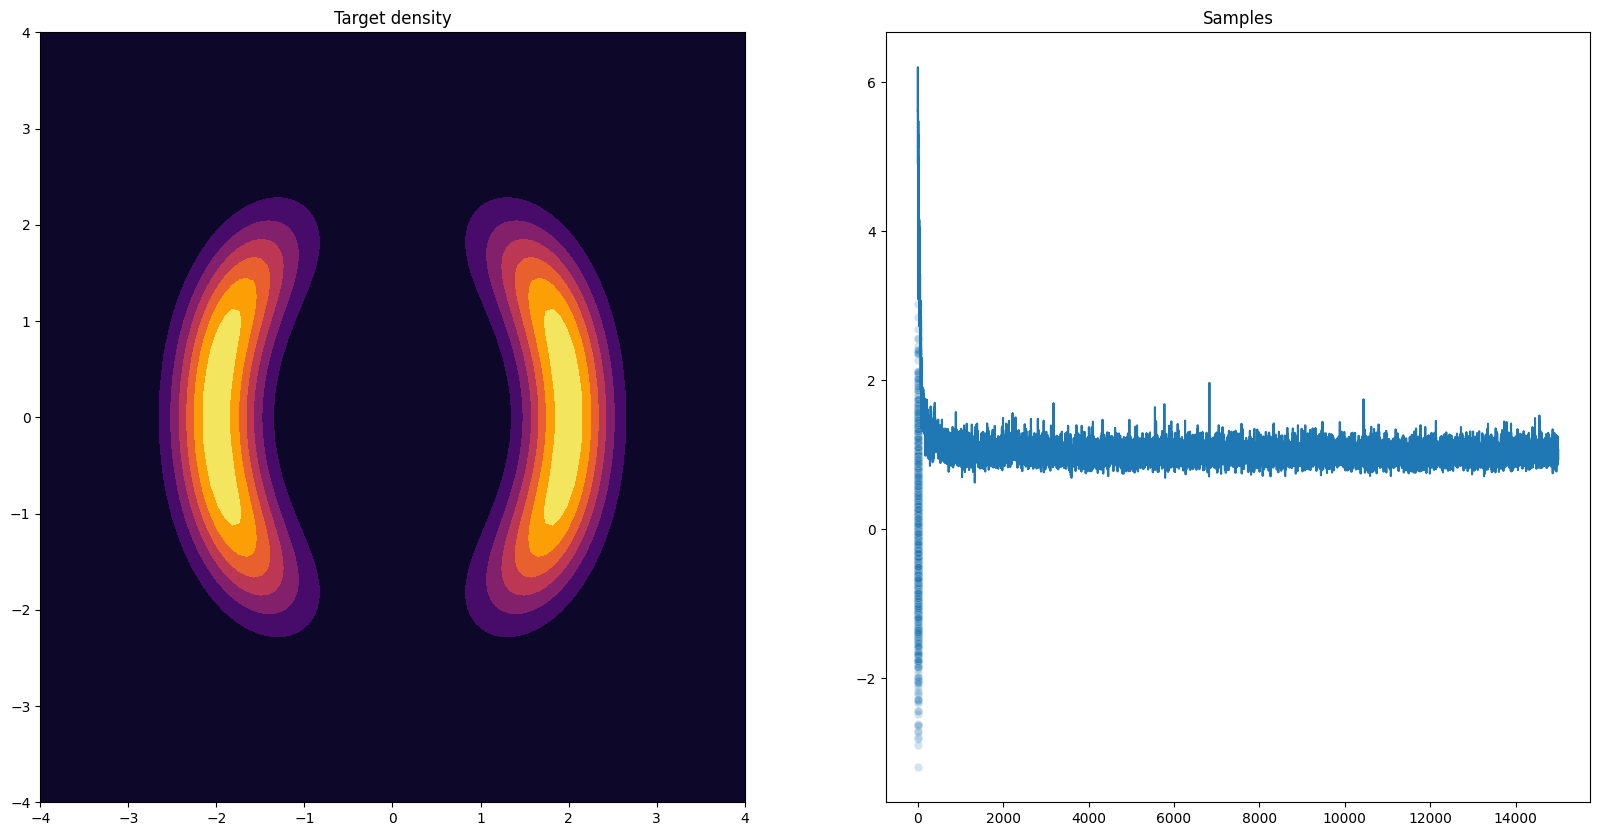

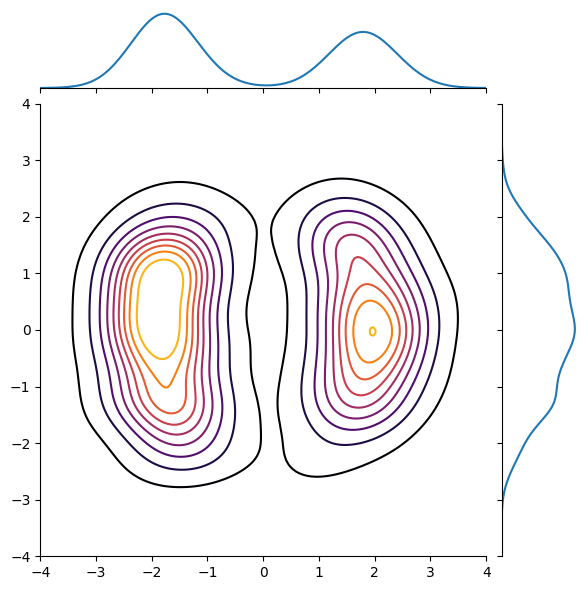

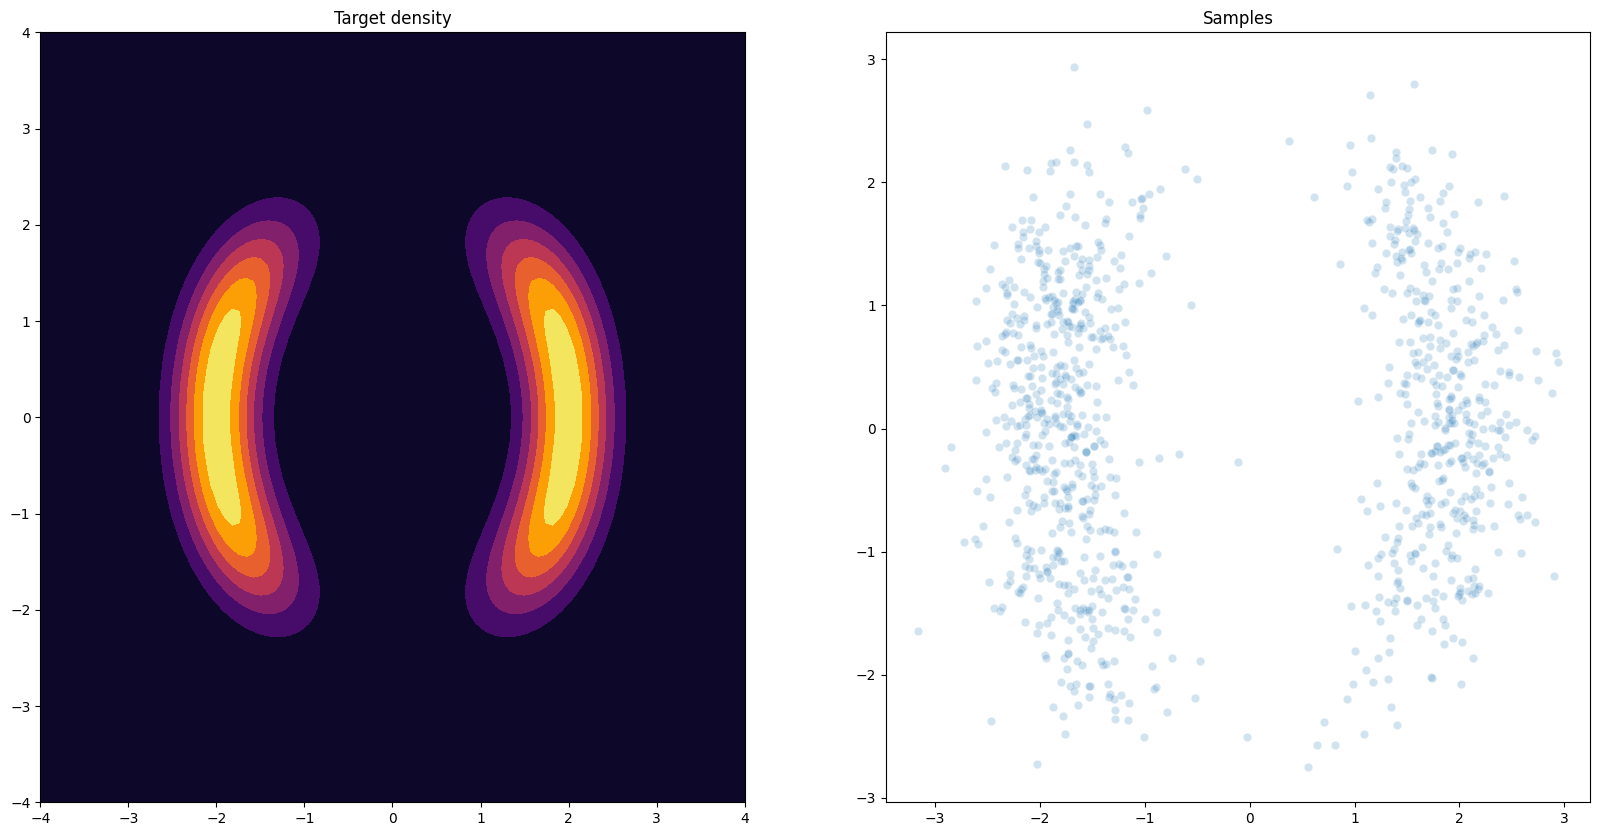

In [24]:
# train gopi

# instantiate new model: 
model = NormalizingFlow(2, n_flows=n_flows)

print("----Plotting Gopi before----")

# plot gopi output before: 
import seaborn as sns 
xsamples = prandom_normal_samples(1000, dim = 2)
zsamples = model.sample(( xsamples )).detach().numpy()

# kde map: 
cmap = plt.get_cmap('inferno')
p = sns.jointplot(x = zsamples[:, 0], y = zsamples[:, 1], kind='kde', cmap=cmap)
p.ax_marg_x.set_xlim(-4, 4)
p.ax_marg_y.set_ylim(-4, 4)

# density and samples
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes = axes.flat
plot_pot_func(target_density, axes[0])
axes[0].set_title('Target density')
sns.scatterplot(x = zsamples[:, 0], y = zsamples[:, 1], alpha=.2, ax=axes[1])
axes[1].set_title('Samples')

print("----Plotting training----")

## now train:RMSprop is what they used in renzende et al
opt = torch.optim.RMSprop(
    params=model.parameters(),
    lr=learning_rate,
    momentum=momentum
)

scheduler = ReduceLROnPlateau(opt, 'min', patience=1000)
losses = []

for iter_ in range(epochs):
    if iter_ % 100 == 0:
        print("Iteration {}".format(iter_))

    samples = Variable(prandom_normal_samples(batch_size, dim = 2))

    z_k, sum_log_det = model(samples)
    log_p_x = target_density(z_k)

    # Reverse KL since we can evaluate target density but can't sample
    loss = (- sum_log_det - (log_p_x)).mean()

    opt.zero_grad()
    loss.backward()
    opt.step()
    scheduler.step(loss)

    losses.append(loss.item())

    if iter_ % 100 == 0:
        print("Loss {}".format(loss.item()))

print("----Plotting Gopi after----")

# plot gopi losses 
plt.plot(losses)

# plot gopi output after: 
import seaborn as sns 
xsamples = prandom_normal_samples(1000, dim = 2)
zsamples = model.sample(( xsamples )).detach().numpy()

# kde map: 
cmap = plt.get_cmap('inferno')
p = sns.jointplot(x = zsamples[:, 0], y = zsamples[:, 1], kind='kde', cmap=cmap)
p.ax_marg_x.set_xlim(-4, 4)
p.ax_marg_y.set_ylim(-4, 4)

# density and samples
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes = axes.flat
plot_pot_func(target_density, axes[0])
axes[0].set_title('Target density')
sns.scatterplot(x = zsamples[:, 0], y = zsamples[:, 1], alpha=.2, ax=axes[1])
axes[1].set_title('Samples')

----Plotting Gopi sans `Variable` before----
----Plotting training----
Iteration 0
Loss 5.529924392700195
Iteration 100
Loss 2.0842745304107666
Iteration 200
Loss 1.3753631114959717
Iteration 300
Loss 1.0396538972854614
Iteration 400
Loss 1.1417491436004639
Iteration 500
Loss 1.0611317157745361
Iteration 600
Loss 1.2007871866226196
Iteration 700
Loss 1.0113681554794312
Iteration 800
Loss 1.064449429512024
Iteration 900
Loss 0.9156256914138794
Iteration 1000
Loss 1.1314419507980347
Iteration 1100
Loss 0.9564443230628967
Iteration 1200
Loss 0.9618434309959412
Iteration 1300
Loss 0.7837521433830261
Iteration 1400
Loss 1.389967918395996
Iteration 1500
Loss 1.0219600200653076
Iteration 1600
Loss 1.086118459701538
Iteration 1700
Loss 1.1317700147628784
Iteration 1800
Loss 0.8873158097267151
Iteration 1900
Loss 0.8552729487419128
Iteration 2000
Loss 0.9986708164215088
Iteration 2100
Loss 0.8878672122955322
Iteration 2200
Loss 1.0334889888763428
Iteration 2300
Loss 1.2162389755249023
Iteration

Text(0.5, 1.0, 'Samples')

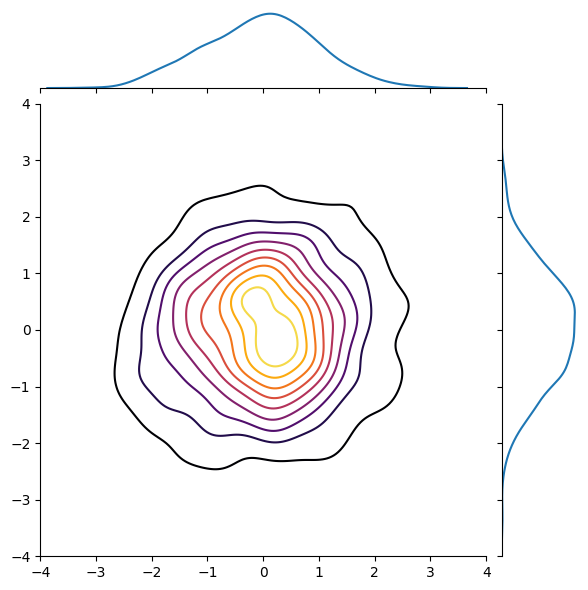

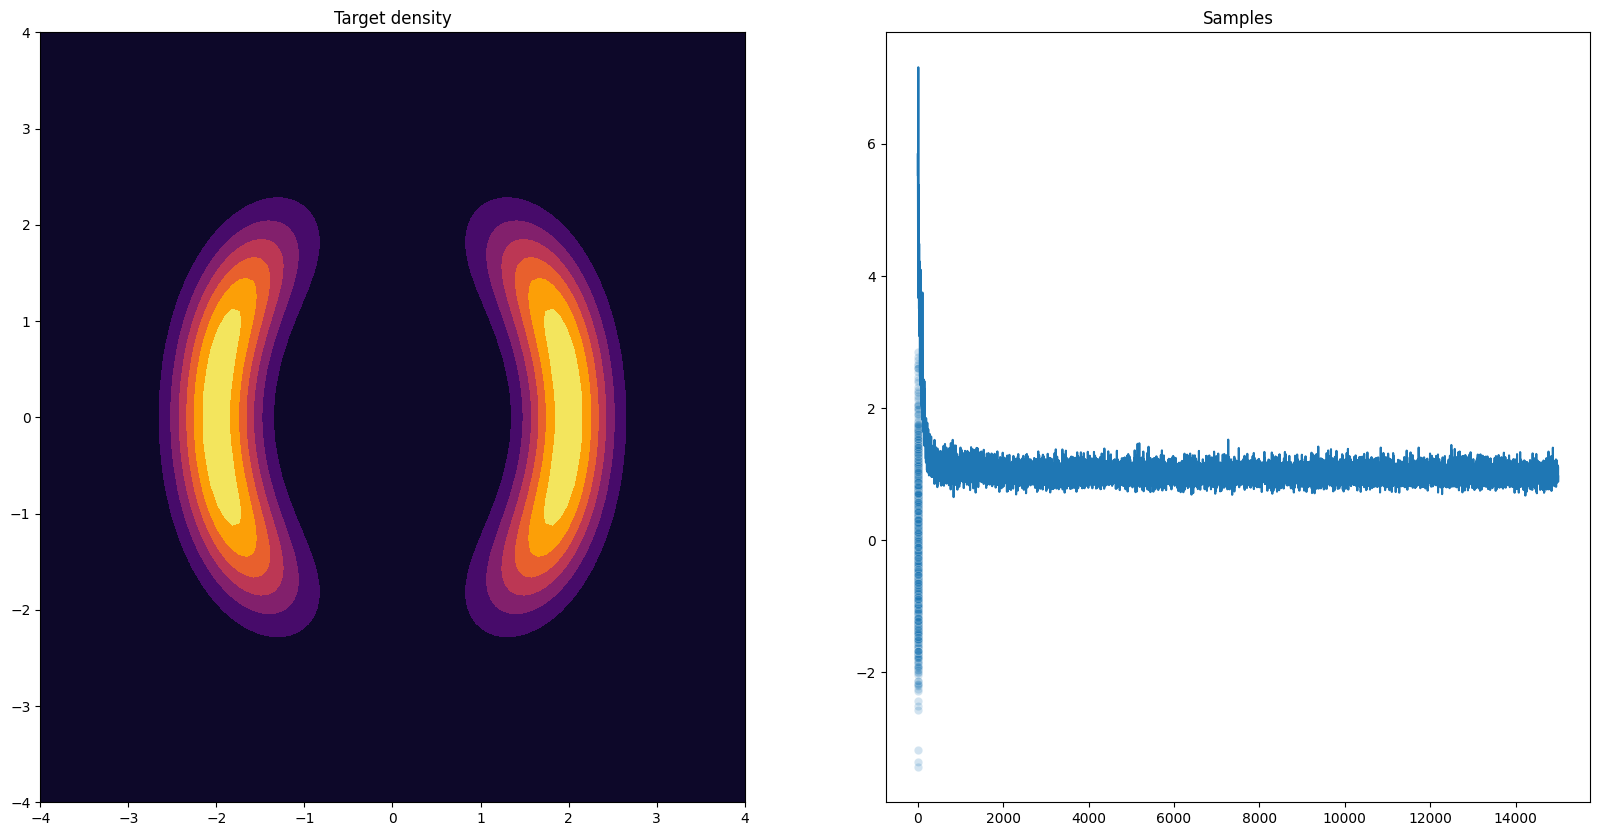

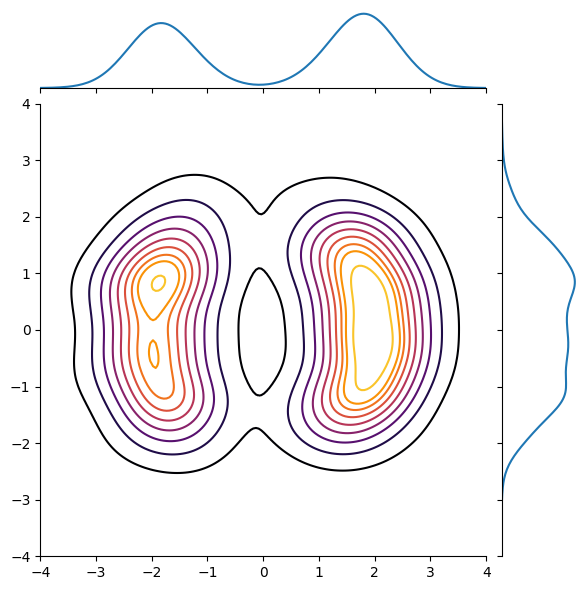

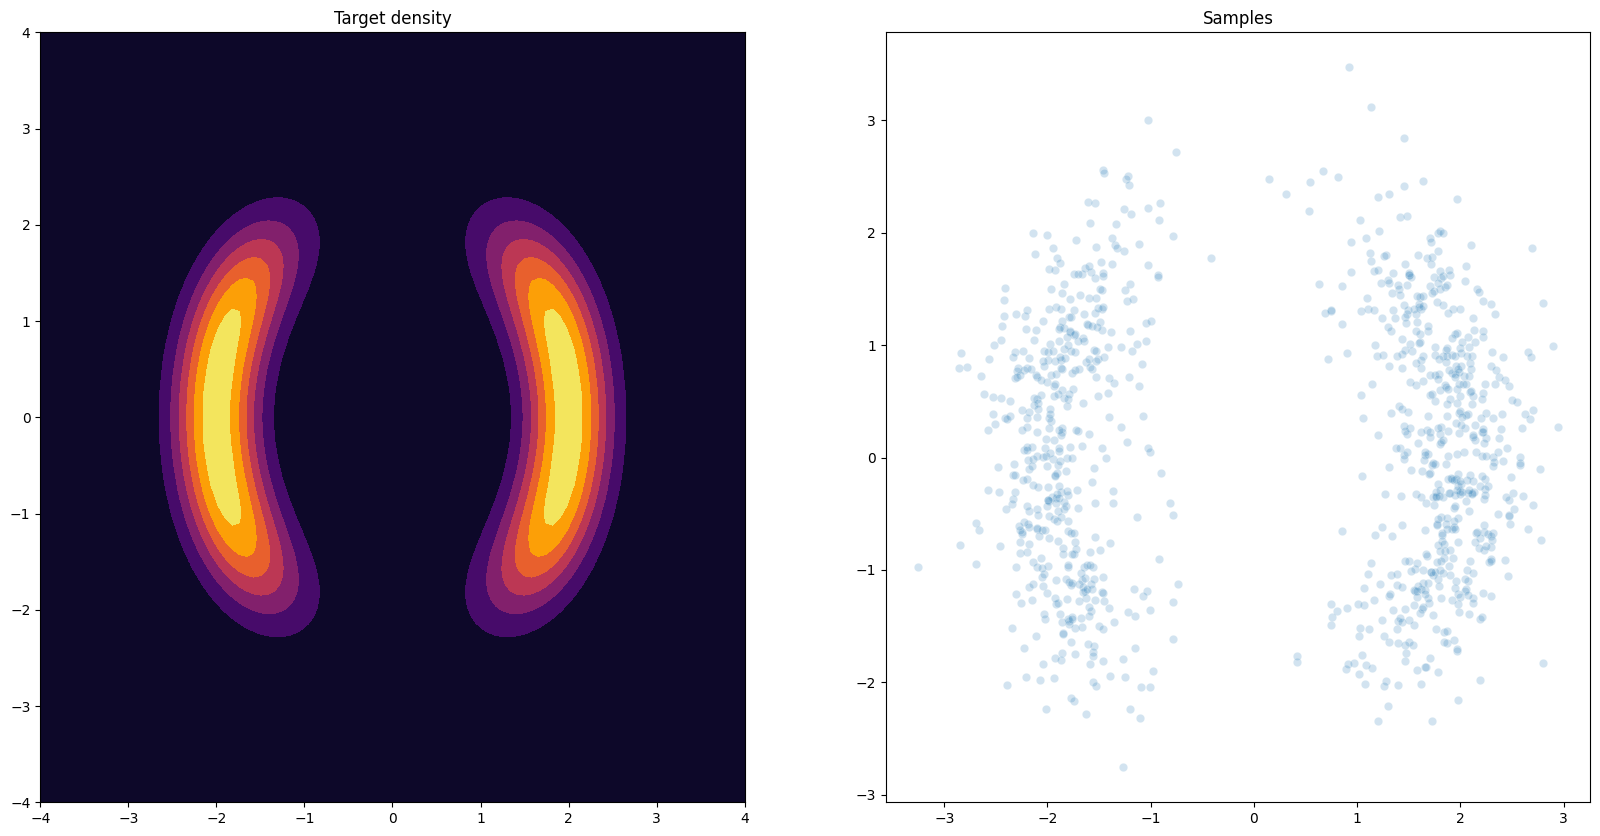

In [30]:
# train gopi without Variable: 

# instantiate new model: 
model = NormalizingFlow(2, n_flows=n_flows)

print("----Plotting Gopi sans `Variable` before----")

# plot gopi output before: 
import seaborn as sns 
xsamples = random_normal_samples(1000, dim = 2)
zsamples = model.sample(( xsamples )).detach().numpy()

# kde map: 
cmap = plt.get_cmap('inferno')
p = sns.jointplot(x = zsamples[:, 0], y = zsamples[:, 1], kind='kde', cmap=cmap)
p.ax_marg_x.set_xlim(-4, 4)
p.ax_marg_y.set_ylim(-4, 4)

# density and samples
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes = axes.flat
plot_pot_func(target_density, axes[0])
axes[0].set_title('Target density')
sns.scatterplot(x = zsamples[:, 0], y = zsamples[:, 1], alpha=.2, ax=axes[1])
axes[1].set_title('Samples')

print("----Plotting training----")

## now train:RMSprop is what they used in renzende et al
opt = torch.optim.RMSprop(
    params=model.parameters(),
    lr=learning_rate,
    momentum=momentum
)

scheduler = ReduceLROnPlateau(opt, 'min', patience=1000)
losses = []

for iter_ in range(epochs):
    if iter_ % 100 == 0:
        print("Iteration {}".format(iter_))

    samples = random_normal_samples(batch_size, dim = 2)

    z_k, sum_log_det = model(samples)
    log_p_x = target_density(z_k)

    # Reverse KL since we can evaluate target density but can't sample
    loss = (- sum_log_det - (log_p_x)).mean()

    opt.zero_grad()
    loss.backward()
    opt.step()
    scheduler.step(loss)

    losses.append(loss.item())

    if iter_ % 100 == 0:
        print("Loss {}".format(loss.item()))

print("----Plotting Gopi sans `Variable` after----")

# plot gopi losses 
plt.plot(losses)

# plot gopi output after: 
import seaborn as sns 
xsamples = random_normal_samples(1000, dim = 2)
zsamples = model.sample(( xsamples )).detach().numpy()

# kde map: 
cmap = plt.get_cmap('inferno')
p = sns.jointplot(x = zsamples[:, 0], y = zsamples[:, 1], kind='kde', cmap=cmap)
p.ax_marg_x.set_xlim(-4, 4)
p.ax_marg_y.set_ylim(-4, 4)

# density and samples
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes = axes.flat
plot_pot_func(target_density, axes[0])
axes[0].set_title('Target density')
sns.scatterplot(x = zsamples[:, 0], y = zsamples[:, 1], alpha=.2, ax=axes[1])
axes[1].set_title('Samples')

----Plotting PPO before----
----Plotting training----
Iteration 0
Loss 5.45235013961792
Iteration 100
Loss 2.272451639175415
Iteration 200
Loss 1.2378865480422974
Iteration 300
Loss 1.329987645149231
Iteration 400
Loss 1.4709539413452148
Iteration 500
Loss 1.3315314054489136
Iteration 600
Loss 1.229142427444458
Iteration 700
Loss 1.1118512153625488
Iteration 800
Loss 1.2101014852523804
Iteration 900
Loss 1.2793225049972534
Iteration 1000
Loss 1.145735740661621
Iteration 1100
Loss 0.9896470904350281
Iteration 1200
Loss 1.1000443696975708
Iteration 1300
Loss 1.06710684299469
Iteration 1400
Loss 1.0741345882415771
Iteration 1500
Loss 1.3046339750289917
Iteration 1600
Loss 1.125077724456787
Iteration 1700
Loss 0.9472929835319519
Iteration 1800
Loss 1.0916404724121094
Iteration 1900
Loss 1.2921638488769531
Iteration 2000
Loss 0.9938717484474182
Iteration 2100
Loss 0.9613577127456665
Iteration 2200
Loss 1.1243398189544678
Iteration 2300
Loss 0.9926471710205078
Iteration 2400
Loss 1.004026412

Text(0.5, 1.0, 'Samples')

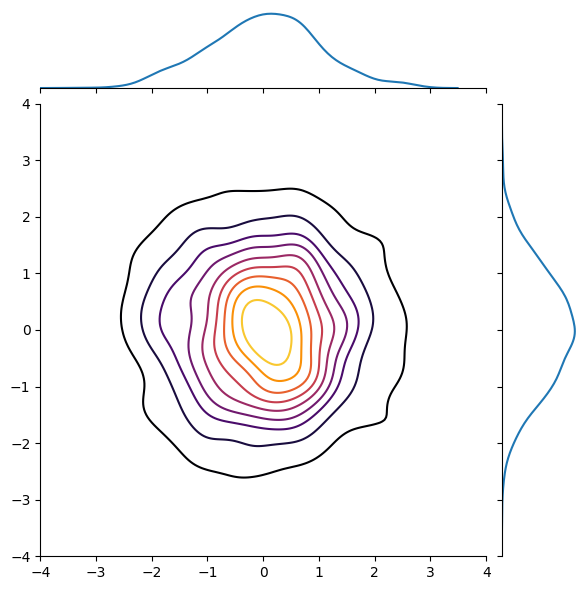

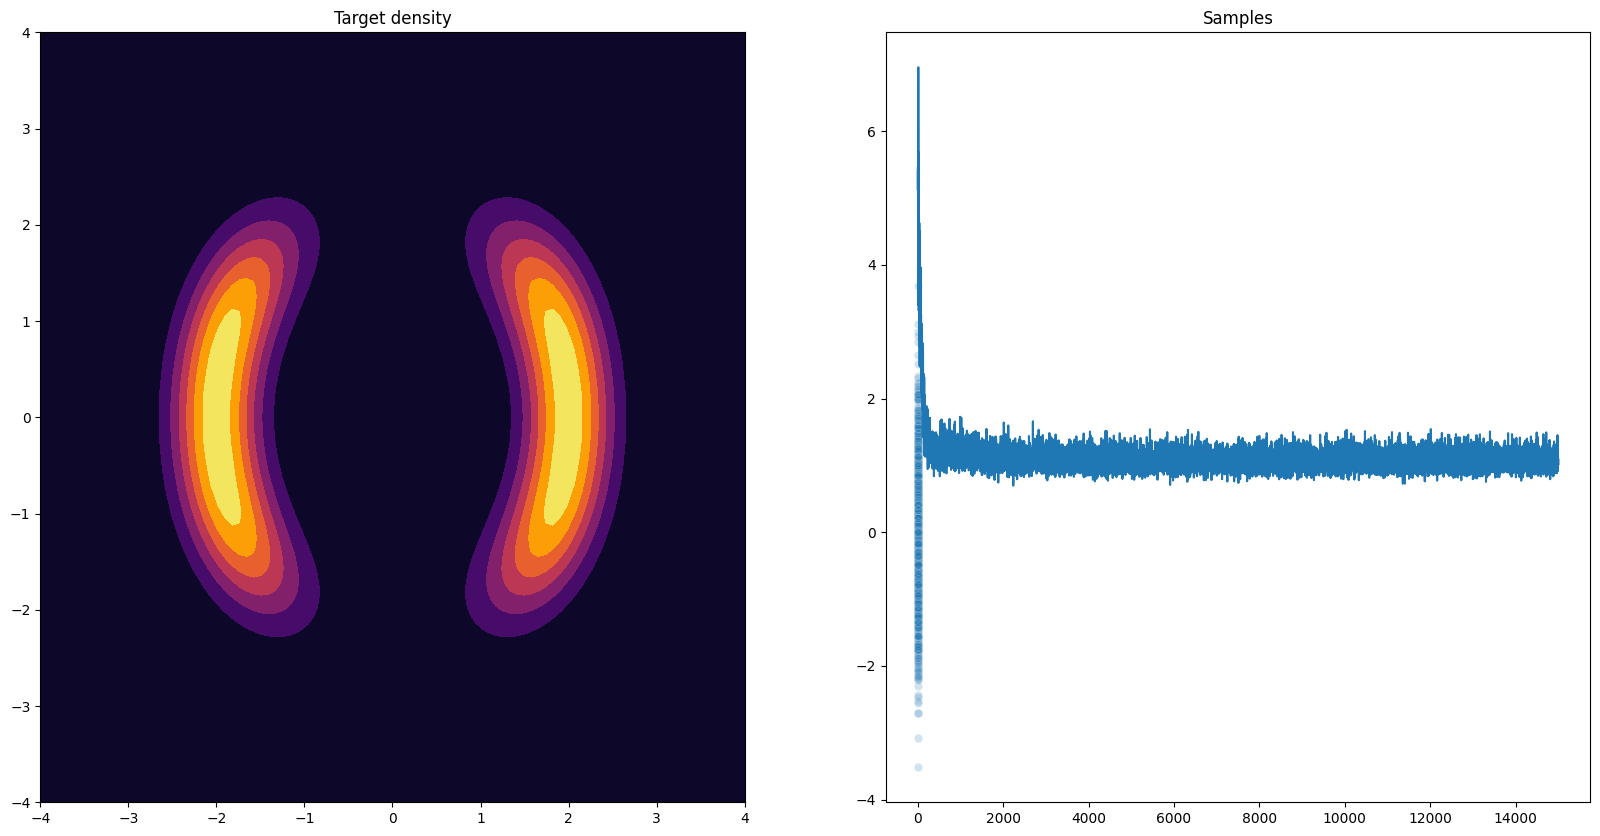

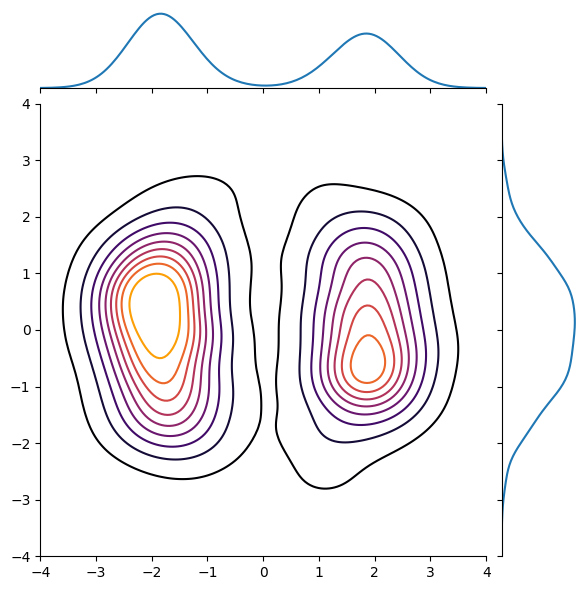

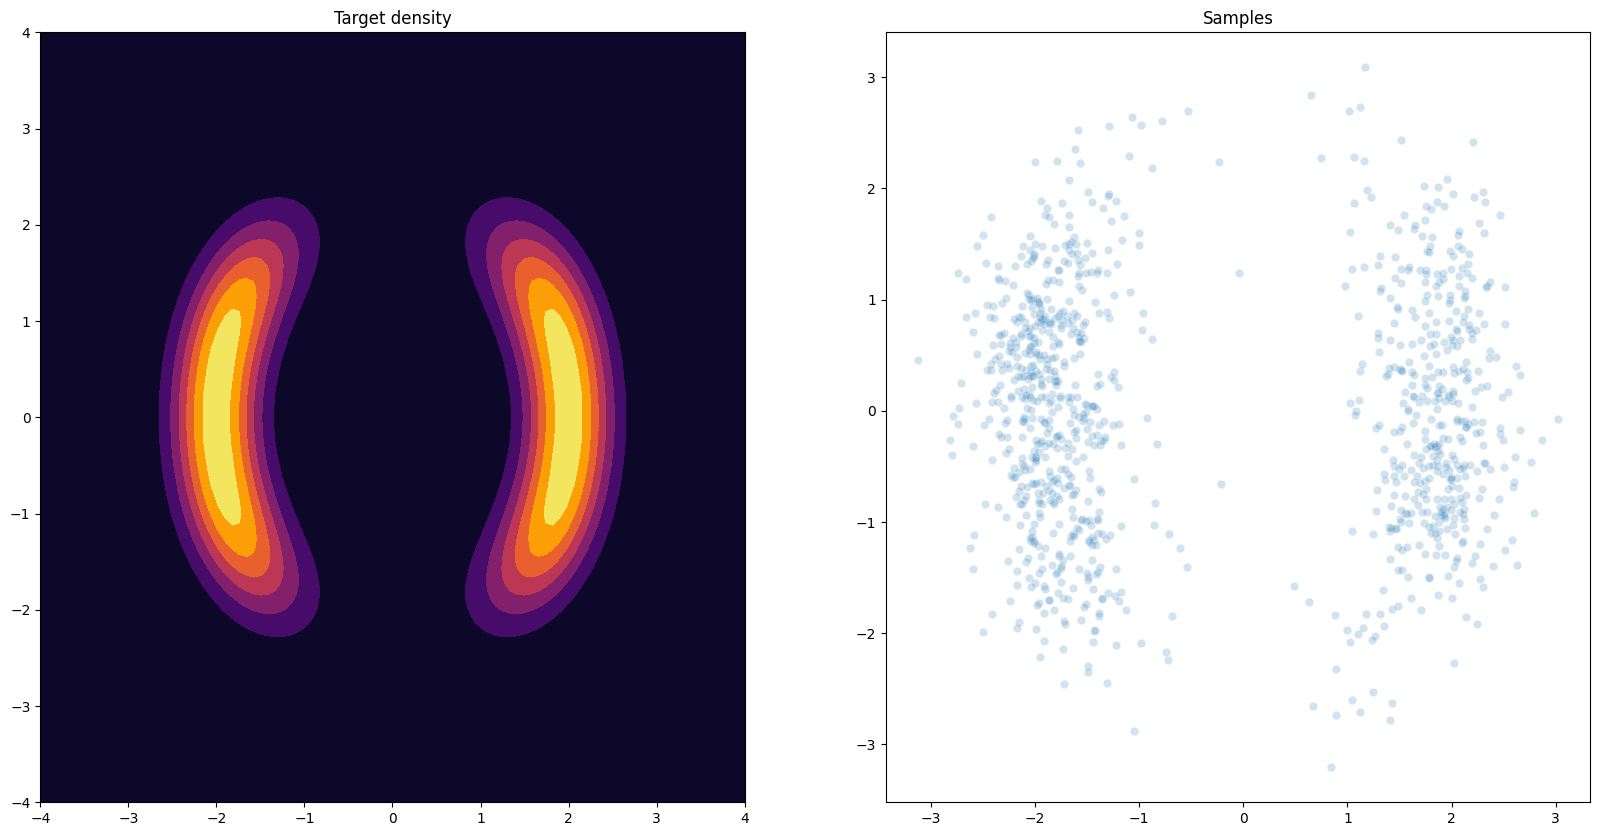

In [31]:
## try our model: 

# instantiate new model: 
model = ppoNormalizingFlow(2, n_flows=n_flows)

print("----Plotting PPO before----")

# plot gopi output before: 
import seaborn as sns 
xsamples = random_normal_samples(1000, dim = 2)
zsamples = model.sample(( xsamples )).detach().numpy()

# kde map: 
cmap = plt.get_cmap('inferno')
p = sns.jointplot(x = zsamples[:, 0], y = zsamples[:, 1], kind='kde', cmap=cmap)
p.ax_marg_x.set_xlim(-4, 4)
p.ax_marg_y.set_ylim(-4, 4)

# density and samples
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes = axes.flat
plot_pot_func(target_density, axes[0])
axes[0].set_title('Target density')
sns.scatterplot(x = zsamples[:, 0], y = zsamples[:, 1], alpha=.2, ax=axes[1])
axes[1].set_title('Samples')

print("----Plotting training----")

## now train:RMSprop is what they used in renzende et al
opt = torch.optim.RMSprop(
    params=model.parameters(),
    lr=learning_rate,
    momentum=momentum
)

scheduler = ReduceLROnPlateau(opt, 'min', patience=1000)
losses = []

for iter_ in range(epochs):
    if iter_ % 100 == 0:
        print("Iteration {}".format(iter_))

    samples = random_normal_samples(batch_size, dim = 2)

    z_k, sum_log_det = model(samples)
    log_p_x = target_density(z_k)

    # Reverse KL since we can evaluate target density but can't sample
    loss = (- sum_log_det - (log_p_x)).mean()

    opt.zero_grad()
    loss.backward()
    opt.step()
    scheduler.step(loss)

    losses.append(loss.item())

    if iter_ % 100 == 0:
        print("Loss {}".format(loss.item()))

print("----Plotting PPO after----")

# plot gopi losses 
plt.plot(losses)

# plot gopi output after: 
import seaborn as sns 
xsamples = random_normal_samples(1000, dim = 2)
zsamples = model.sample(( xsamples )).detach().numpy()

# kde map: 
cmap = plt.get_cmap('inferno')
p = sns.jointplot(x = zsamples[:, 0], y = zsamples[:, 1], kind='kde', cmap=cmap)
p.ax_marg_x.set_xlim(-4, 4)
p.ax_marg_y.set_ylim(-4, 4)

# density and samples
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes = axes.flat
plot_pot_func(target_density, axes[0])
axes[0].set_title('Target density')
sns.scatterplot(x = zsamples[:, 0], y = zsamples[:, 1], alpha=.2, ax=axes[1])
axes[1].set_title('Samples')

----Plotting PPO with `Variable` before----
----Plotting training----
Iteration 0
Loss 5.062866687774658
Iteration 100
Loss 3.1103622913360596
Iteration 200
Loss 2.1551196575164795
Iteration 300
Loss 1.6118091344833374
Iteration 400
Loss 1.3012968301773071
Iteration 500
Loss 1.1613526344299316
Iteration 600
Loss 1.2794994115829468
Iteration 700
Loss 1.3148399591445923
Iteration 800
Loss 1.2775055170059204
Iteration 900
Loss 1.3039991855621338
Iteration 1000
Loss 1.214331865310669
Iteration 1100
Loss 0.9884323477745056
Iteration 1200
Loss 0.9185786247253418
Iteration 1300
Loss 1.1428978443145752
Iteration 1400
Loss 1.489440679550171
Iteration 1500
Loss 1.321379542350769
Iteration 1600
Loss 1.1448335647583008
Iteration 1700
Loss 1.186371922492981
Iteration 1800
Loss 1.04539155960083
Iteration 1900
Loss 1.0199068784713745
Iteration 2000
Loss 1.0875449180603027
Iteration 2100
Loss 1.3638300895690918
Iteration 2200
Loss 1.253908634185791
Iteration 2300
Loss 1.1718248128890991
Iteration 2400

Text(0.5, 1.0, 'Samples')

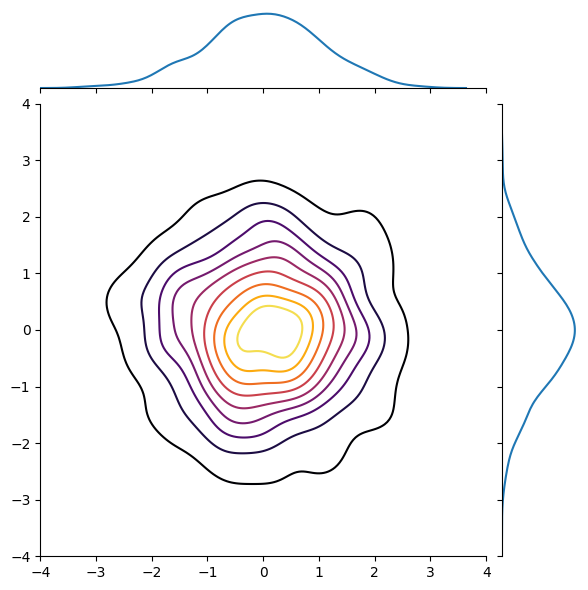

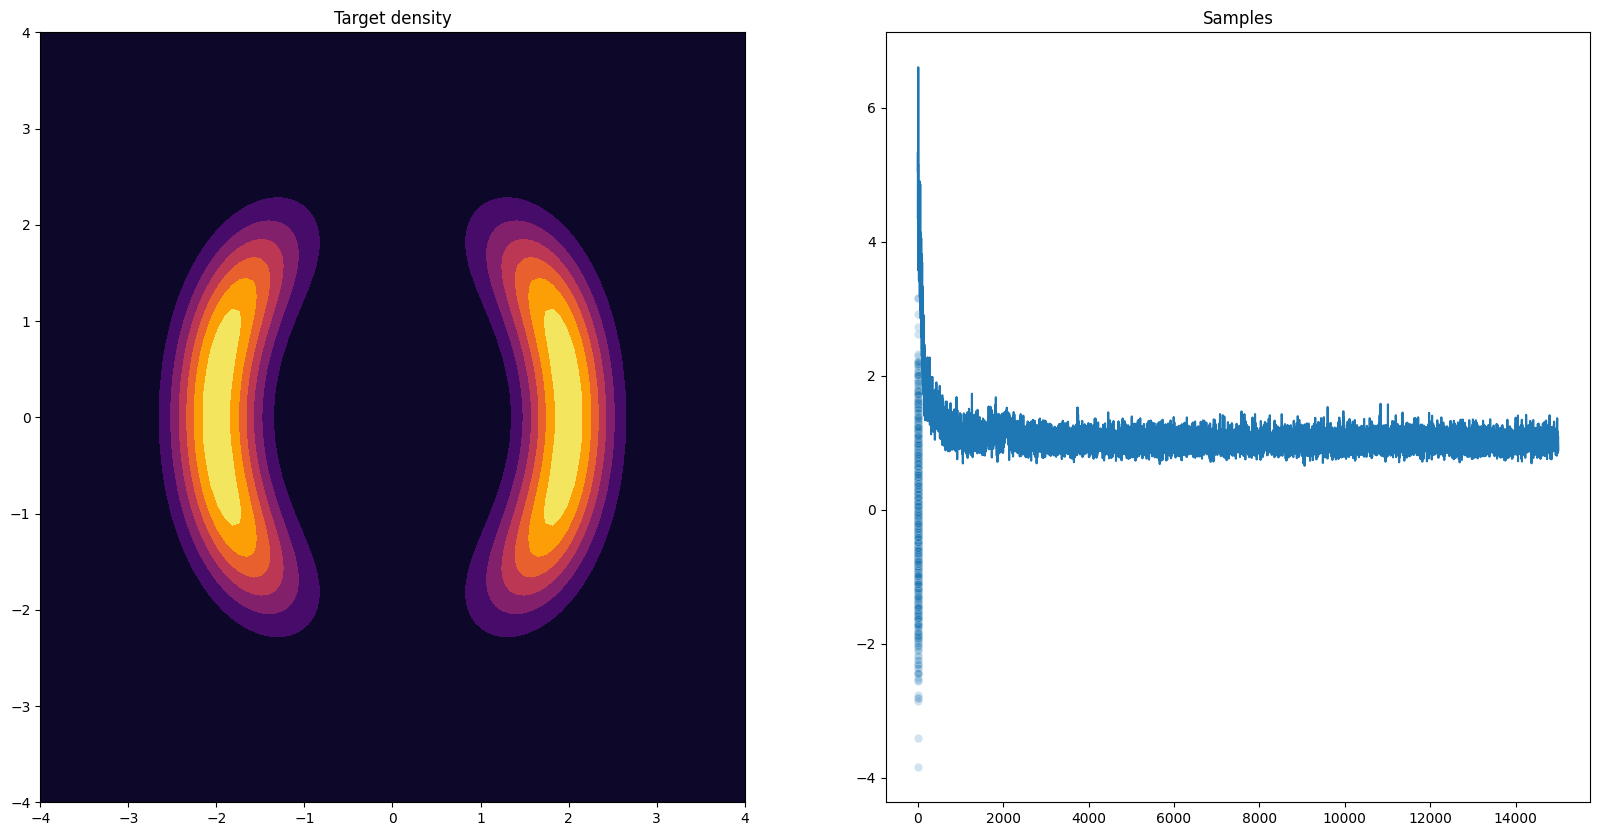

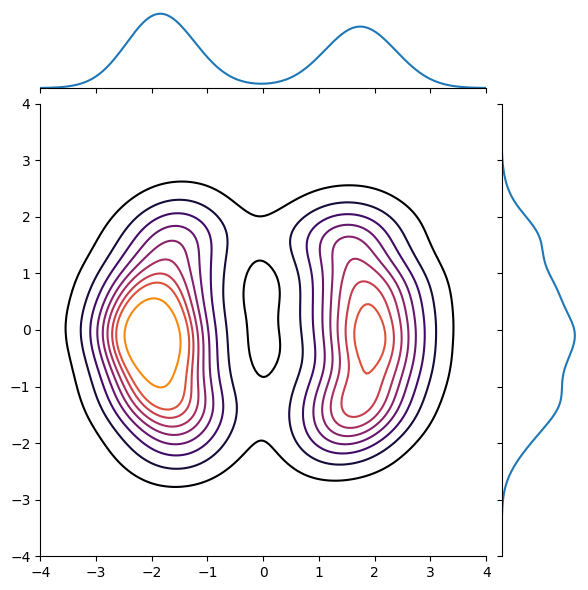

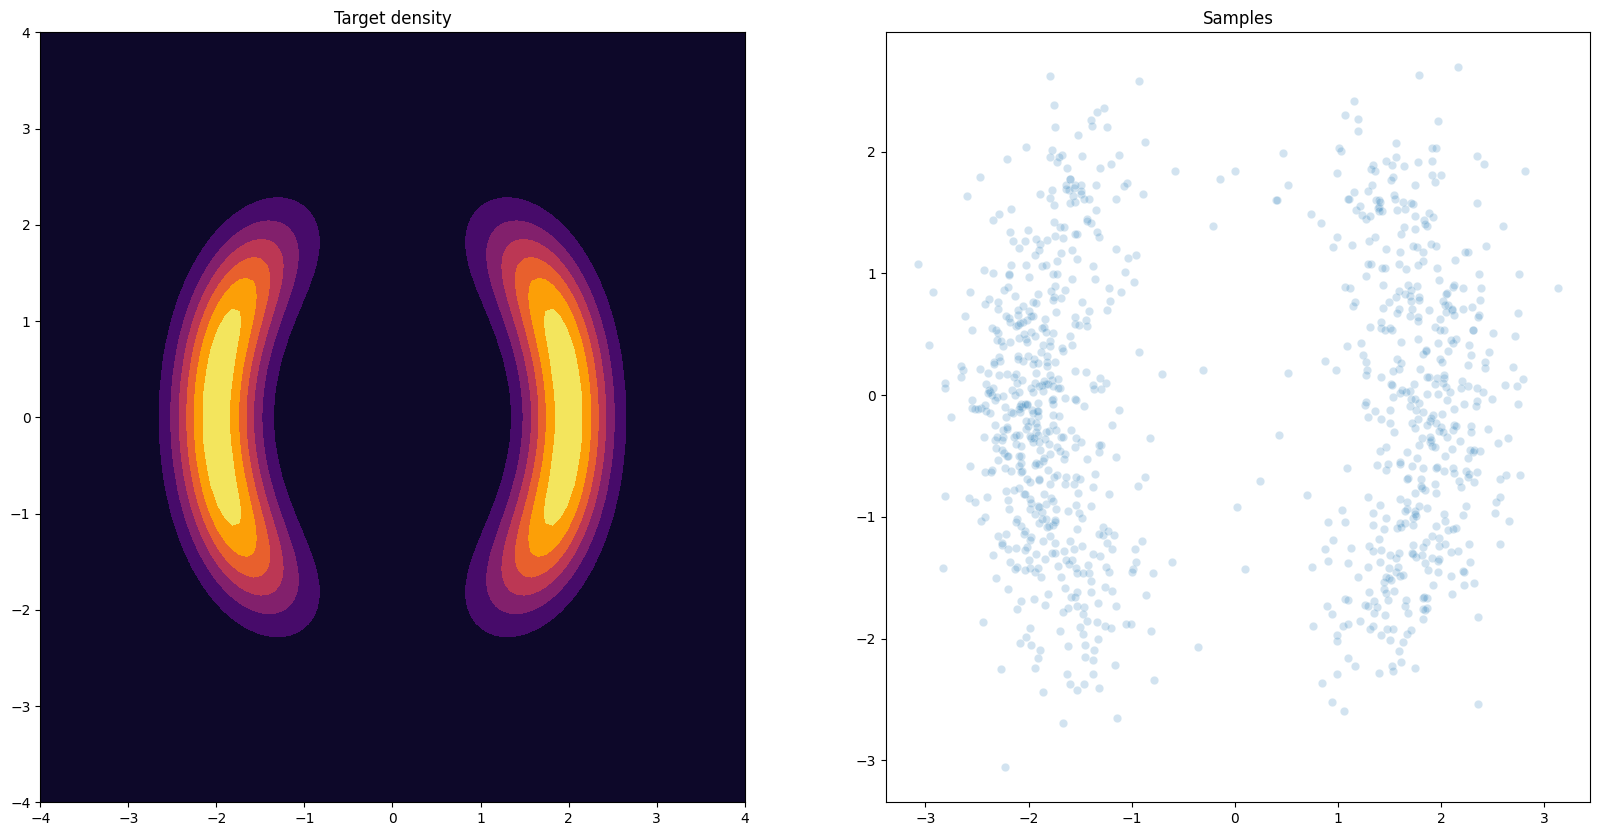

In [32]:
## try our model with Variable: 

# instantiate new model: 
model = ppoNormalizingFlow(2, n_flows=n_flows)

print("----Plotting PPO with `Variable` before----")

# plot gopi output before: 
import seaborn as sns 
xsamples = random_normal_samples(1000, dim = 2)
zsamples = model.sample(( xsamples )).detach().numpy()

# kde map: 
cmap = plt.get_cmap('inferno')
p = sns.jointplot(x = zsamples[:, 0], y = zsamples[:, 1], kind='kde', cmap=cmap)
p.ax_marg_x.set_xlim(-4, 4)
p.ax_marg_y.set_ylim(-4, 4)

# density and samples
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes = axes.flat
plot_pot_func(target_density, axes[0])
axes[0].set_title('Target density')
sns.scatterplot(x = zsamples[:, 0], y = zsamples[:, 1], alpha=.2, ax=axes[1])
axes[1].set_title('Samples')

print("----Plotting training----")

## now train:RMSprop is what they used in renzende et al
opt = torch.optim.RMSprop(
    params=model.parameters(),
    lr=learning_rate,
    momentum=momentum
)

scheduler = ReduceLROnPlateau(opt, 'min', patience=1000)
losses = []

for iter_ in range(epochs):
    if iter_ % 100 == 0:
        print("Iteration {}".format(iter_))

    samples = Variable(random_normal_samples(batch_size, dim = 2)) 

    z_k, sum_log_det = model(samples)
    log_p_x = target_density(z_k)

    # Reverse KL since we can evaluate target density but can't sample
    loss = (- sum_log_det - (log_p_x)).mean()

    opt.zero_grad()
    loss.backward()
    opt.step()
    scheduler.step(loss)

    losses.append(loss.item())

    if iter_ % 100 == 0:
        print("Loss {}".format(loss.item()))

print("----Plotting PPO after----")

# plot gopi losses 
plt.plot(losses)

# plot gopi output after: 
import seaborn as sns 
xsamples = random_normal_samples(1000, dim = 2)
zsamples = model.sample(( xsamples )).detach().numpy()

# kde map: 
cmap = plt.get_cmap('inferno')
p = sns.jointplot(x = zsamples[:, 0], y = zsamples[:, 1], kind='kde', cmap=cmap)
p.ax_marg_x.set_xlim(-4, 4)
p.ax_marg_y.set_ylim(-4, 4)

# density and samples
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes = axes.flat
plot_pot_func(target_density, axes[0])
axes[0].set_title('Target density')
sns.scatterplot(x = zsamples[:, 0], y = zsamples[:, 1], alpha=.2, ax=axes[1])
axes[1].set_title('Samples')

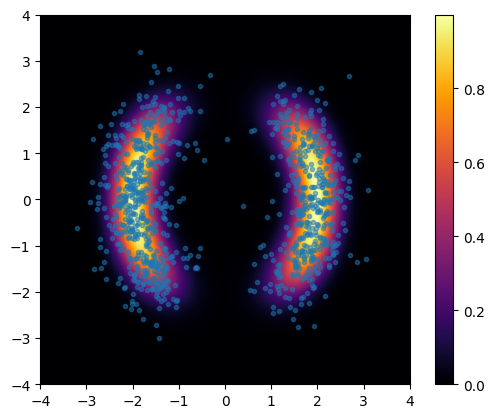

In [33]:
## check some density plotting of his and ours: 

from ppo_code.plotting_utils import plot_2d_model_and_target
plot_2d_model_and_target(pot_1, model)

### Train and compare results on potential 2

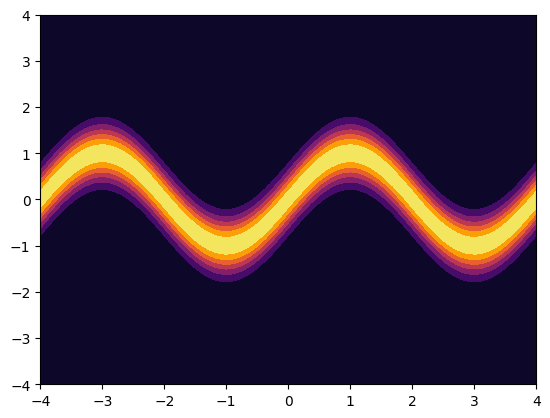

In [9]:
from src.densities import pot_2
target_density = pot_2 

plot_pot_func(pot_2)


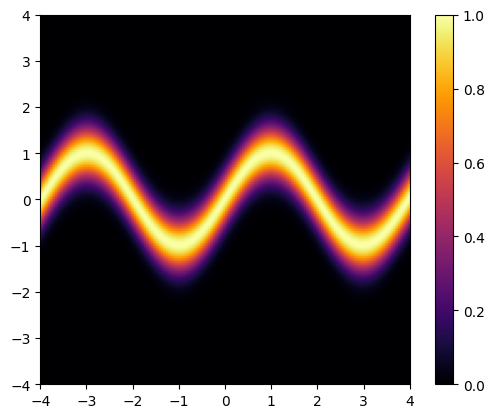

In [10]:

plot_2D_potential(pot_2)

In [13]:

# hyperparameters: 
n_flows = 16
batch_size = 100 
learning_rate = .001 
epochs = 15000

momentum = .9

----Plotting Gopi before----
----Plotting training----
Iteration 0
Loss 5.340123653411865
Iteration 100
Loss 1.8498305082321167
Iteration 200
Loss 1.186192274093628
Iteration 300
Loss 0.8986750841140747
Iteration 400
Loss 0.8714401125907898
Iteration 500
Loss 0.9391811490058899
Iteration 600
Loss 0.762261152267456
Iteration 700
Loss 0.9337135553359985
Iteration 800
Loss 0.6553792357444763
Iteration 900
Loss 0.7100658416748047
Iteration 1000
Loss 0.5305331349372864
Iteration 1100
Loss 0.5217092037200928
Iteration 1200
Loss 0.7325591444969177
Iteration 1300
Loss 0.54282146692276
Iteration 1400
Loss 0.45858779549598694
Iteration 1500
Loss 0.37365972995758057
Iteration 1600
Loss 0.5224235653877258
Iteration 1700
Loss 0.4206896126270294
Iteration 1800
Loss 0.3578054904937744
Iteration 1900
Loss 0.34698957204818726
Iteration 2000
Loss 0.47423627972602844
Iteration 2100
Loss 0.20528100430965424
Iteration 2200
Loss 0.17323821783065796
Iteration 2300
Loss 0.24980801343917847
Iteration 2400
Loss

Text(0.5, 1.0, 'Samples')

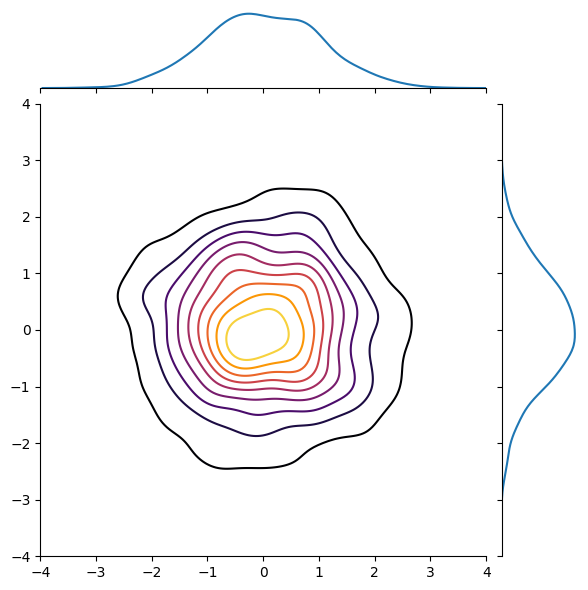

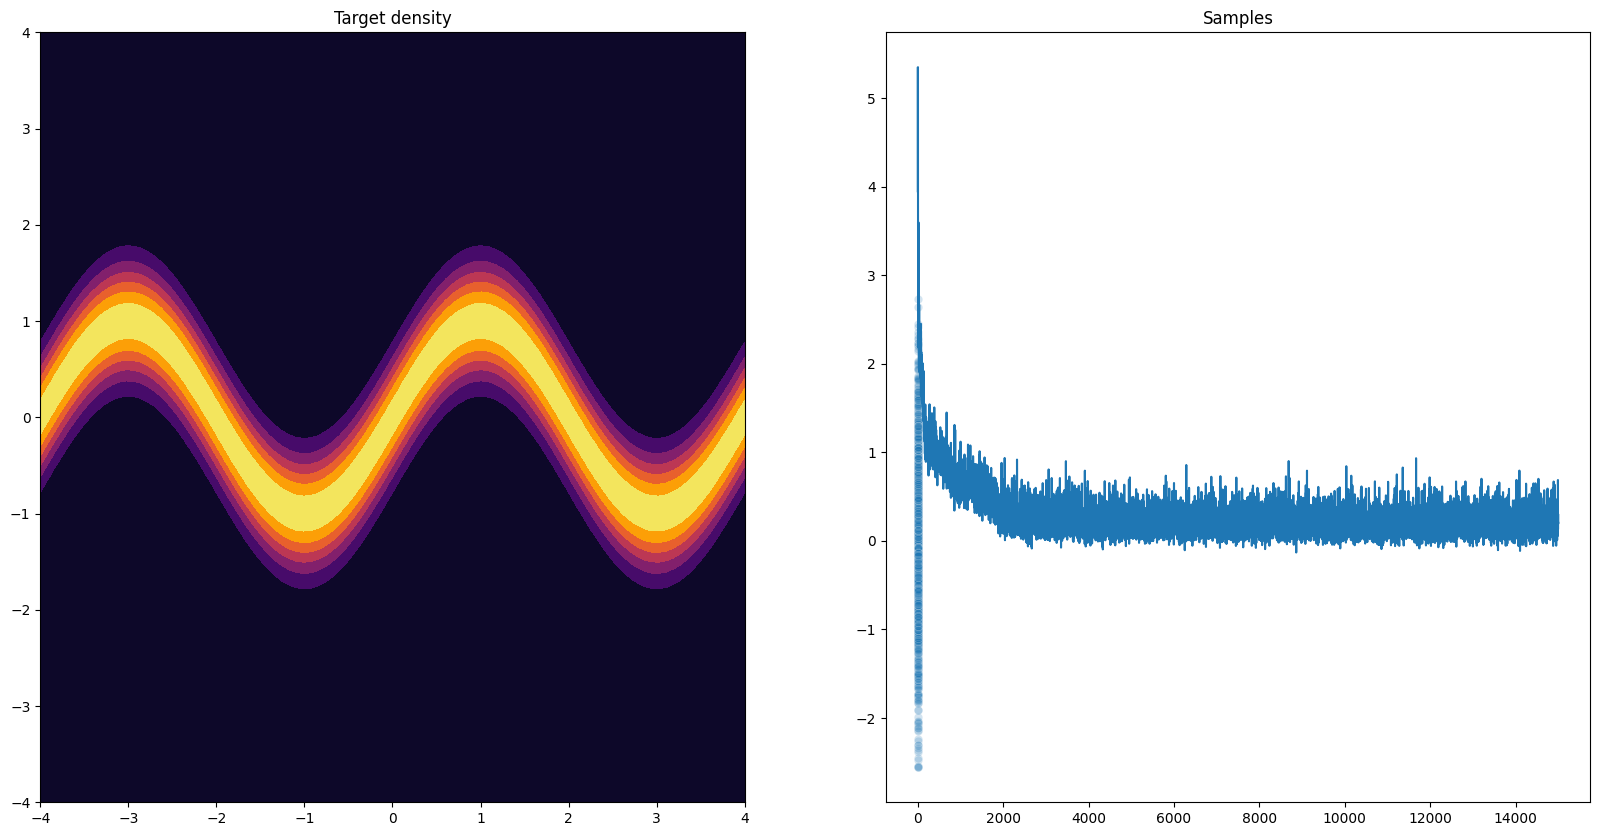

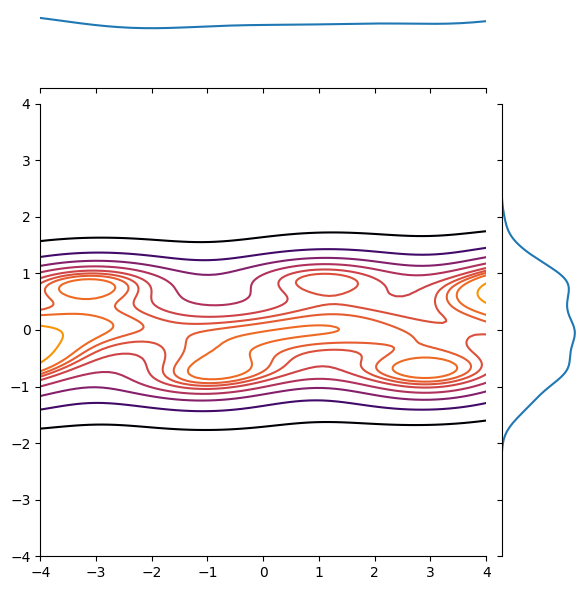

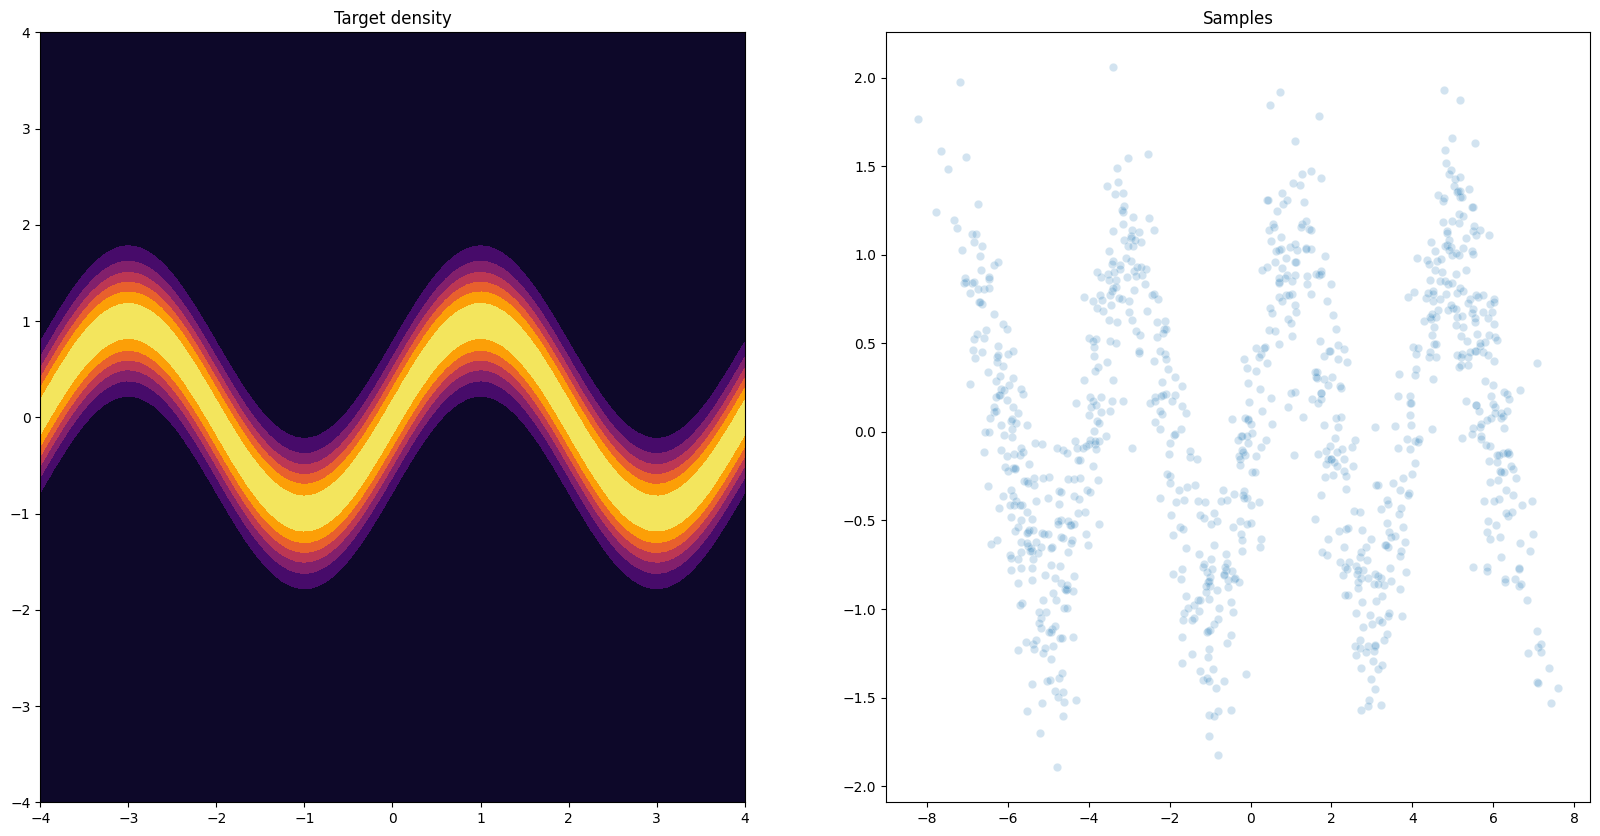

In [39]:
# train gopi

# instantiate new model: 
model = NormalizingFlow(2, n_flows=n_flows)

print("----Plotting Gopi before----")

# plot gopi output before: 
import seaborn as sns 
xsamples = prandom_normal_samples(1000, dim = 2)
zsamples = model.sample(( xsamples )).detach().numpy()

# kde map: 
cmap = plt.get_cmap('inferno')
p = sns.jointplot(x = zsamples[:, 0], y = zsamples[:, 1], kind='kde', cmap=cmap)
p.ax_marg_x.set_xlim(-4, 4)
p.ax_marg_y.set_ylim(-4, 4)

# density and samples
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes = axes.flat
plot_pot_func(target_density, axes[0])
axes[0].set_title('Target density')
sns.scatterplot(x = zsamples[:, 0], y = zsamples[:, 1], alpha=.2, ax=axes[1])
axes[1].set_title('Samples')

print("----Plotting training----")

## now train:RMSprop is what they used in renzende et al
opt = torch.optim.RMSprop(
    params=model.parameters(),
    lr=learning_rate,
    momentum=momentum
)

scheduler = ReduceLROnPlateau(opt, 'min', patience=1000)
losses = []

for iter_ in range(epochs):
    if iter_ % 100 == 0:
        print("Iteration {}".format(iter_))

    samples = Variable(prandom_normal_samples(batch_size, dim = 2))

    z_k, sum_log_det = model(samples)
    log_p_x = target_density(z_k)

    # Reverse KL since we can evaluate target density but can't sample
    loss = (- sum_log_det - (log_p_x)).mean()

    opt.zero_grad()
    loss.backward()
    opt.step()
    scheduler.step(loss)

    losses.append(loss.item())

    if iter_ % 100 == 0:
        print("Loss {}".format(loss.item()))

print("----Plotting Gopi after----")

# plot gopi losses 
plt.plot(losses)

# plot gopi output after: 
import seaborn as sns 
xsamples = prandom_normal_samples(1000, dim = 2)
zsamples = model.sample(( xsamples )).detach().numpy()

# kde map: 
cmap = plt.get_cmap('inferno')
p = sns.jointplot(x = zsamples[:, 0], y = zsamples[:, 1], kind='kde', cmap=cmap)
p.ax_marg_x.set_xlim(-4, 4)
p.ax_marg_y.set_ylim(-4, 4)

# density and samples
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes = axes.flat
plot_pot_func(target_density, axes[0])
axes[0].set_title('Target density')
sns.scatterplot(x = zsamples[:, 0], y = zsamples[:, 1], alpha=.2, ax=axes[1])
axes[1].set_title('Samples')

----Plotting Gopi sans `Variable` before----
----Plotting training----
Iteration 0
Loss 4.204305648803711
Iteration 100
Loss 2.165910005569458
Iteration 200
Loss 1.2051512002944946
Iteration 300
Loss 0.9297295808792114
Iteration 400
Loss 0.9649138450622559
Iteration 500
Loss 0.790873110294342
Iteration 600
Loss 0.9241456985473633
Iteration 700
Loss 0.9985557794570923
Iteration 800
Loss 0.7803727388381958
Iteration 900
Loss 0.6910617351531982
Iteration 1000
Loss 0.5653079748153687
Iteration 1100
Loss 0.6301146745681763
Iteration 1200
Loss 0.48873770236968994
Iteration 1300
Loss 0.5369007587432861
Iteration 1400
Loss 0.376460462808609
Iteration 1500
Loss 0.4244407117366791
Iteration 1600
Loss 0.5166802406311035
Iteration 1700
Loss 0.638768196105957
Iteration 1800
Loss 0.5627326369285583
Iteration 1900
Loss 0.566231369972229
Iteration 2000
Loss 0.7384029626846313
Iteration 2100
Loss 0.4898086488246918
Iteration 2200
Loss 0.426101416349411
Iteration 2300
Loss 0.5452598929405212
Iteration 2

Text(0.5, 1.0, 'Samples')

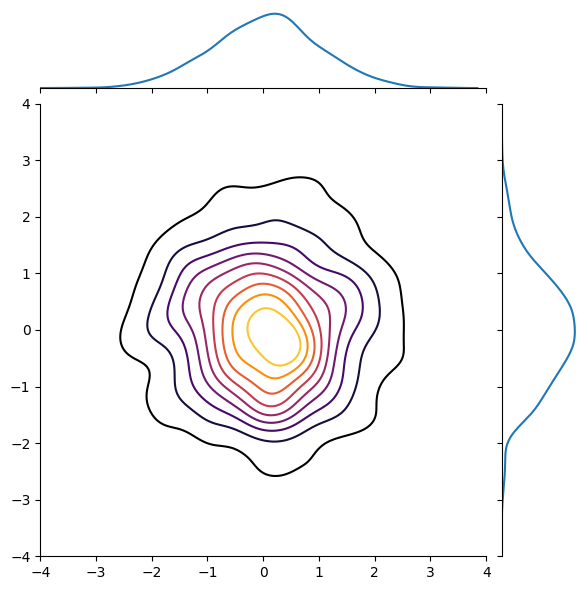

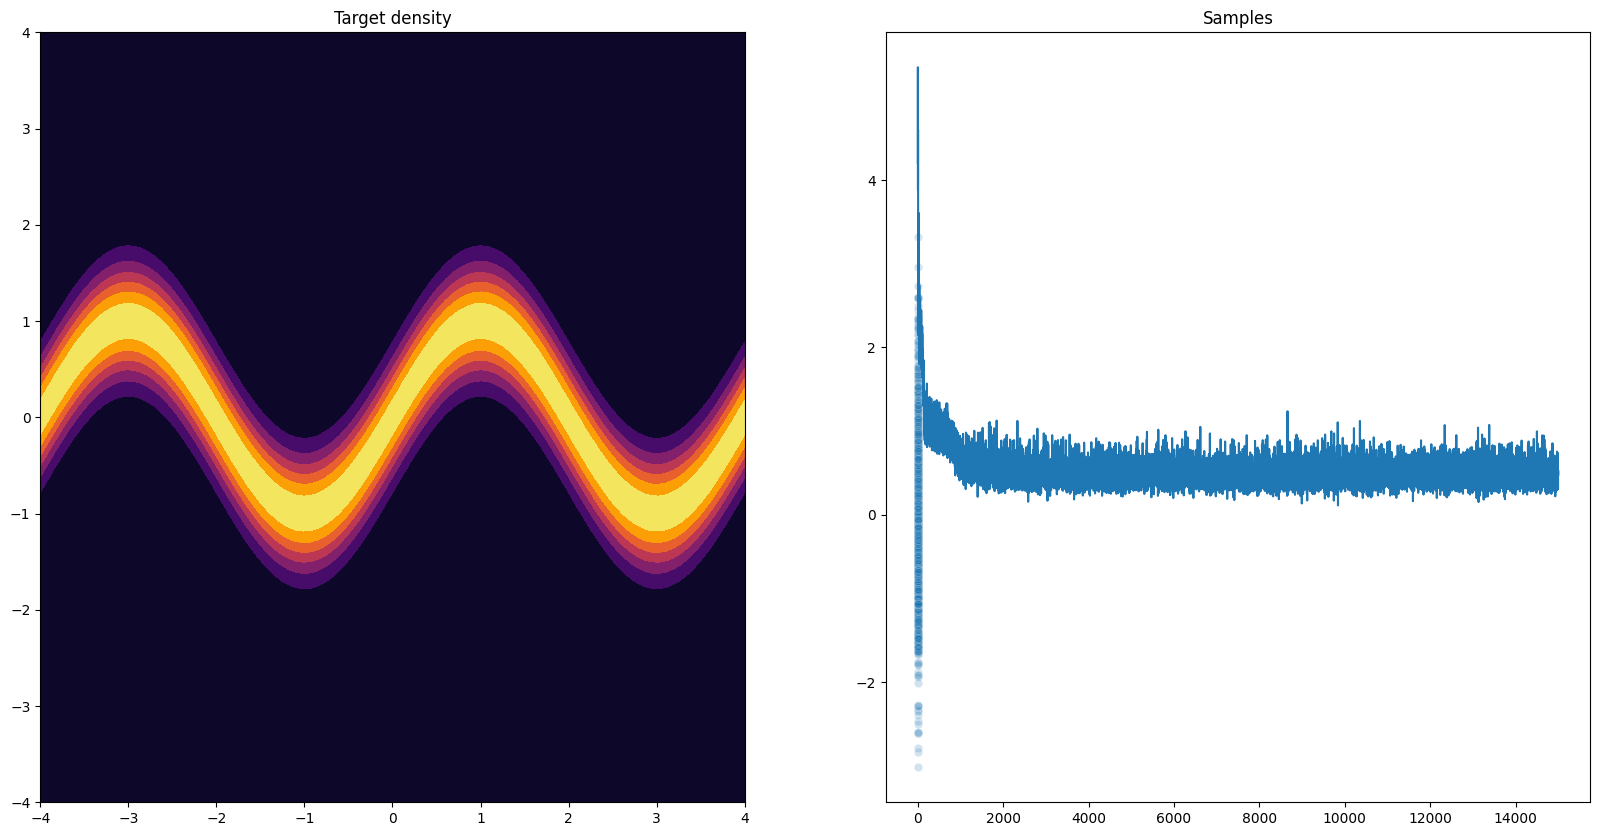

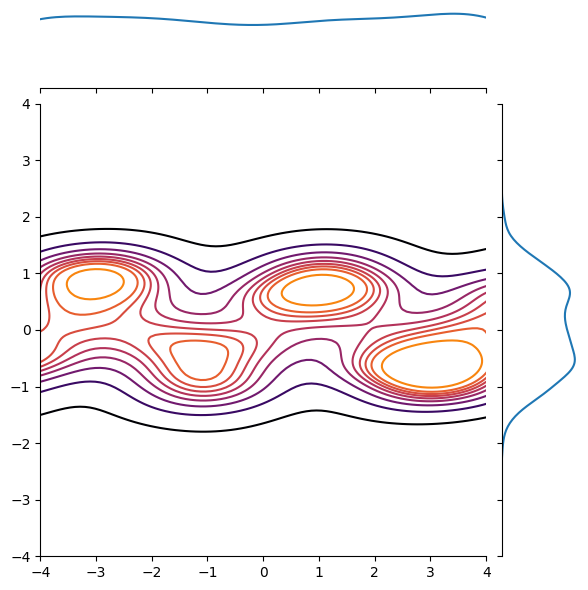

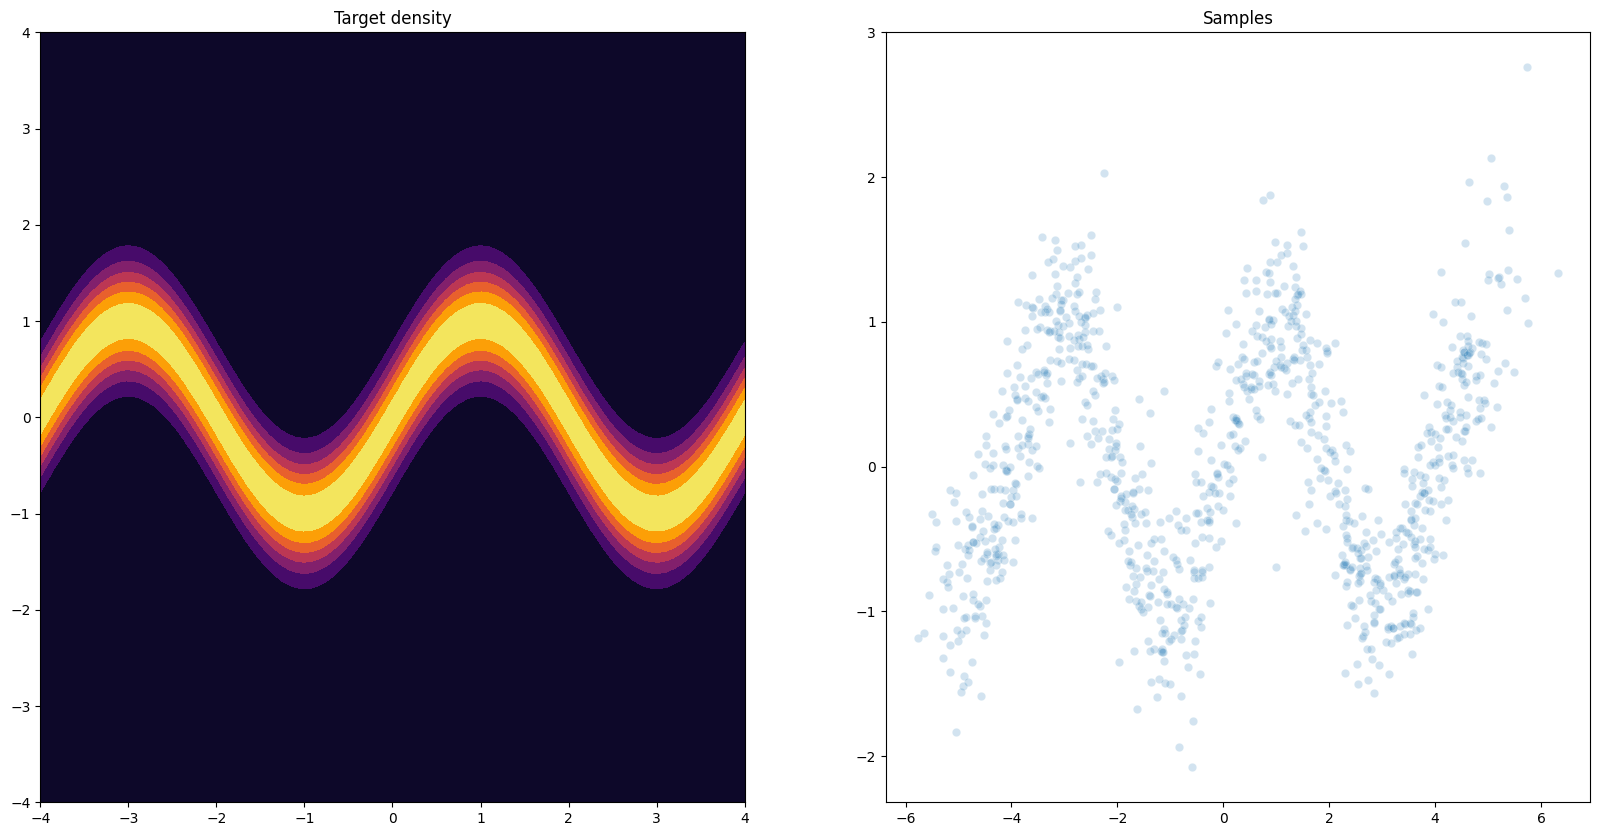

In [40]:
# train gopi without Variable: 

# instantiate new model: 
model = NormalizingFlow(2, n_flows=n_flows)

print("----Plotting Gopi sans `Variable` before----")

# plot gopi output before: 
import seaborn as sns 
xsamples = random_normal_samples(1000, dim = 2)
zsamples = model.sample(( xsamples )).detach().numpy()

# kde map: 
cmap = plt.get_cmap('inferno')
p = sns.jointplot(x = zsamples[:, 0], y = zsamples[:, 1], kind='kde', cmap=cmap)
p.ax_marg_x.set_xlim(-4, 4)
p.ax_marg_y.set_ylim(-4, 4)

# density and samples
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes = axes.flat
plot_pot_func(target_density, axes[0])
axes[0].set_title('Target density')
sns.scatterplot(x = zsamples[:, 0], y = zsamples[:, 1], alpha=.2, ax=axes[1])
axes[1].set_title('Samples')

print("----Plotting training----")

## now train:RMSprop is what they used in renzende et al
opt = torch.optim.RMSprop(
    params=model.parameters(),
    lr=learning_rate,
    momentum=momentum
)

scheduler = ReduceLROnPlateau(opt, 'min', patience=1000)
losses = []

for iter_ in range(epochs):
    if iter_ % 100 == 0:
        print("Iteration {}".format(iter_))

    samples = random_normal_samples(batch_size, dim = 2)

    z_k, sum_log_det = model(samples)
    log_p_x = target_density(z_k)

    # Reverse KL since we can evaluate target density but can't sample
    loss = (- sum_log_det - (log_p_x)).mean()

    opt.zero_grad()
    loss.backward()
    opt.step()
    scheduler.step(loss)

    losses.append(loss.item())

    if iter_ % 100 == 0:
        print("Loss {}".format(loss.item()))

print("----Plotting Gopi sans `Variable` after----")

# plot gopi losses 
plt.plot(losses)

# plot gopi output after: 
import seaborn as sns 
xsamples = random_normal_samples(1000, dim = 2)
zsamples = model.sample(( xsamples )).detach().numpy()

# kde map: 
cmap = plt.get_cmap('inferno')
p = sns.jointplot(x = zsamples[:, 0], y = zsamples[:, 1], kind='kde', cmap=cmap)
p.ax_marg_x.set_xlim(-4, 4)
p.ax_marg_y.set_ylim(-4, 4)

# density and samples
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes = axes.flat
plot_pot_func(target_density, axes[0])
axes[0].set_title('Target density')
sns.scatterplot(x = zsamples[:, 0], y = zsamples[:, 1], alpha=.2, ax=axes[1])
axes[1].set_title('Samples')

----Plotting PPO before----
----Plotting training----
Iteration 0
Loss 4.8552117347717285
Iteration 100
Loss 1.8762809038162231
Iteration 200
Loss 1.013997197151184
Iteration 300
Loss 1.3873634338378906
Iteration 400
Loss 1.2777162790298462
Iteration 500
Loss 1.1440367698669434
Iteration 600
Loss 1.0740584135055542
Iteration 700
Loss 0.9822434782981873
Iteration 800
Loss 0.9668239951133728
Iteration 900
Loss 0.9785277247428894
Iteration 1000
Loss 0.7462410926818848
Iteration 1100
Loss 0.9184592962265015
Iteration 1200
Loss 0.611519992351532
Iteration 1300
Loss 0.7026022672653198
Iteration 1400
Loss 0.6893057227134705
Iteration 1500
Loss 0.7012295126914978
Iteration 1600
Loss 0.674649715423584
Iteration 1700
Loss 0.5460889339447021
Iteration 1800
Loss 0.6201132535934448
Iteration 1900
Loss 0.5688275098800659
Iteration 2000
Loss 0.6123391389846802
Iteration 2100
Loss 0.500098466873169
Iteration 2200
Loss 0.6746728420257568
Iteration 2300
Loss 0.4133463501930237
Iteration 2400
Loss 0.5527

Text(0.5, 1.0, 'Samples')

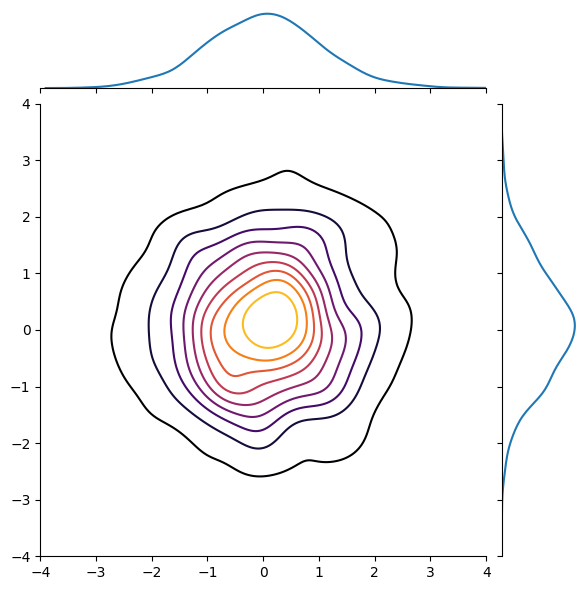

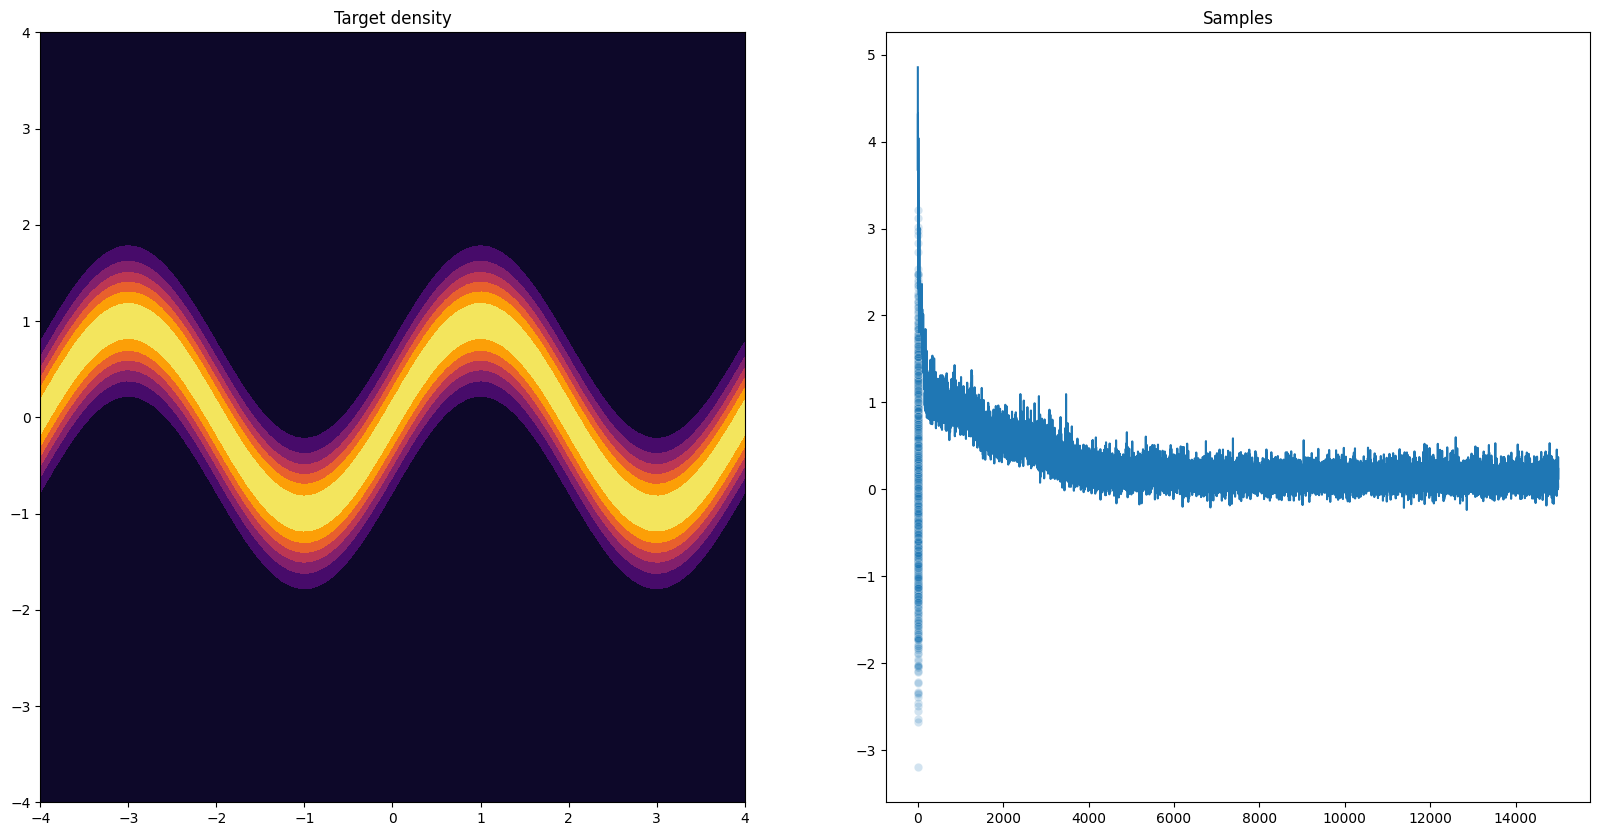

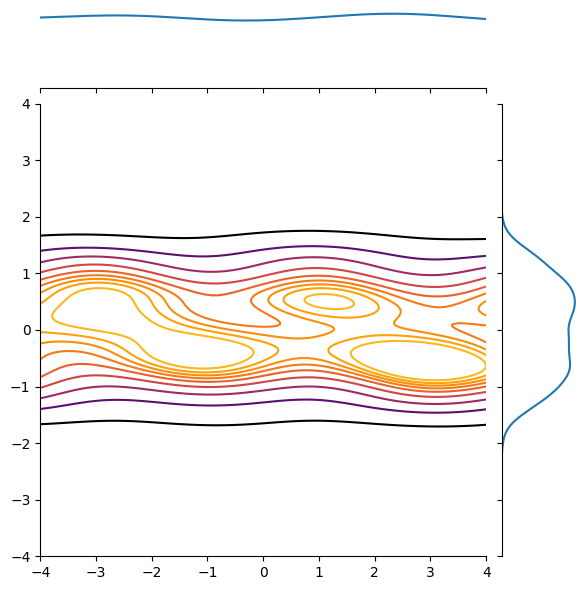

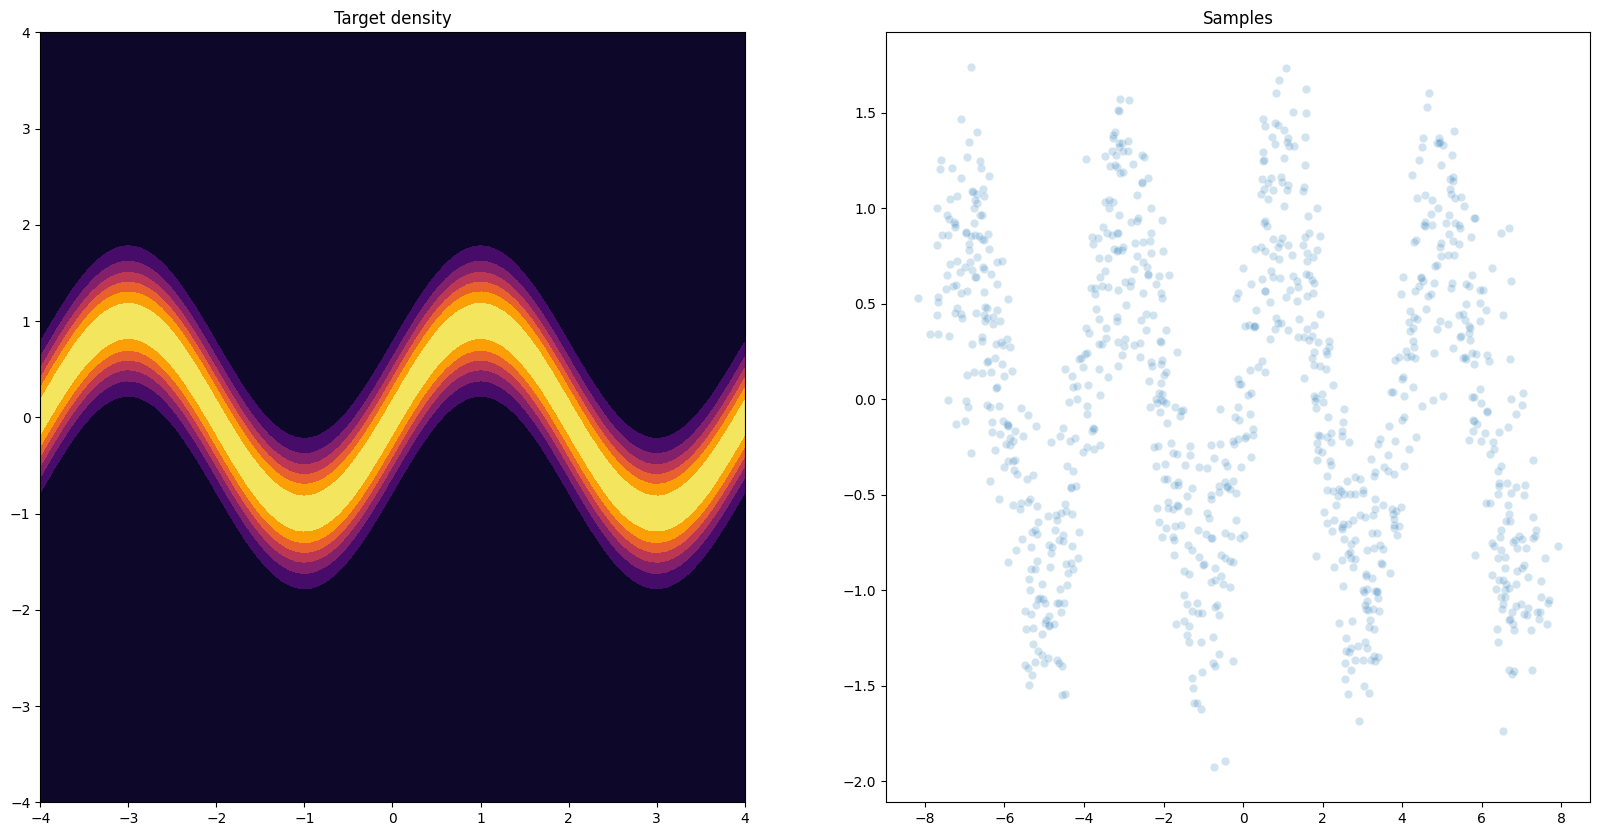

In [43]:
## try our model: 

# instantiate new model: 
model = ppoNormalizingFlow(2, n_flows=n_flows)

print("----Plotting PPO before----")

# plot gopi output before: 
import seaborn as sns 
xsamples = random_normal_samples(1000, dim = 2)
zsamples = model.sample(( xsamples )).detach().numpy()

# kde map: 
cmap = plt.get_cmap('inferno')
p = sns.jointplot(x = zsamples[:, 0], y = zsamples[:, 1], kind='kde', cmap=cmap)
p.ax_marg_x.set_xlim(-4, 4)
p.ax_marg_y.set_ylim(-4, 4)

# density and samples
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes = axes.flat
plot_pot_func(target_density, axes[0])
axes[0].set_title('Target density')
sns.scatterplot(x = zsamples[:, 0], y = zsamples[:, 1], alpha=.2, ax=axes[1])
axes[1].set_title('Samples')

print("----Plotting training----")

## now train:RMSprop is what they used in renzende et al
opt = torch.optim.RMSprop(
    params=model.parameters(),
    lr=learning_rate,
    momentum=momentum
)

scheduler = ReduceLROnPlateau(opt, 'min', patience=1000)
losses = []

for iter_ in range(epochs):
    if iter_ % 100 == 0:
        print("Iteration {}".format(iter_))

    samples = random_normal_samples(batch_size, dim = 2)

    z_k, sum_log_det = model(samples)
    log_p_x = target_density(z_k)

    # Reverse KL since we can evaluate target density but can't sample
    loss = (- sum_log_det - (log_p_x)).mean()

    opt.zero_grad()
    loss.backward()
    opt.step()
    scheduler.step(loss)

    losses.append(loss.item())

    if iter_ % 100 == 0:
        print("Loss {}".format(loss.item()))

print("----Plotting PPO after----")

# plot gopi losses 
plt.plot(losses)

# plot gopi output after: 
import seaborn as sns 
xsamples = random_normal_samples(1000, dim = 2)
zsamples = model.sample(( xsamples )).detach().numpy()

# kde map: 
cmap = plt.get_cmap('inferno')
p = sns.jointplot(x = zsamples[:, 0], y = zsamples[:, 1], kind='kde', cmap=cmap)
p.ax_marg_x.set_xlim(-4, 4)
p.ax_marg_y.set_ylim(-4, 4)

# density and samples
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes = axes.flat
plot_pot_func(target_density, axes[0])
axes[0].set_title('Target density')
sns.scatterplot(x = zsamples[:, 0], y = zsamples[:, 1], alpha=.2, ax=axes[1])
axes[1].set_title('Samples')

In [12]:
## try our model with Variable: 

# instantiate new model: 
model = ppoNormalizingFlow(2, n_flows=n_flows)

print("----Plotting PPO with `Variable` before----")

# plot gopi output before: 
import seaborn as sns 
xsamples = random_normal_samples(1000, dim = 2)
zsamples = model.sample(( xsamples )).detach().numpy()

# kde map: 
cmap = plt.get_cmap('inferno')
p = sns.jointplot(x = zsamples[:, 0], y = zsamples[:, 1], kind='kde', cmap=cmap)
p.ax_marg_x.set_xlim(-4, 4)
p.ax_marg_y.set_ylim(-4, 4)

# density and samples
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes = axes.flat
plot_pot_func(target_density, axes[0])
axes[0].set_title('Target density')
sns.scatterplot(x = zsamples[:, 0], y = zsamples[:, 1], alpha=.2, ax=axes[1])
axes[1].set_title('Samples')

print("----Plotting training----")

## now train:RMSprop is what they used in renzende et al
opt = torch.optim.RMSprop(
    params=model.parameters(),
    lr=learning_rate,
    momentum=momentum
)

scheduler = ReduceLROnPlateau(opt, 'min', patience=1000)
losses = []

for iter_ in range(epochs):
    if iter_ % 100 == 0:
        print("Iteration {}".format(iter_))

    samples = Variable(random_normal_samples(batch_size, dim = 2)) 

    z_k, sum_log_det = model(samples)
    log_p_x = target_density(z_k)

    # Reverse KL since we can evaluate target density but can't sample
    loss = (- sum_log_det - (log_p_x)).mean()

    opt.zero_grad()
    loss.backward()
    opt.step()
    scheduler.step(loss)

    losses.append(loss.item())

    if iter_ % 100 == 0:
        print("Loss {}".format(loss.item()))

print("----Plotting PPO after----")

# plot gopi losses 
plt.plot(losses)

# plot gopi output after: 
import seaborn as sns 
xsamples = random_normal_samples(1000, dim = 2)
zsamples = model.sample(( xsamples )).detach().numpy()

# kde map: 
cmap = plt.get_cmap('inferno')
p = sns.jointplot(x = zsamples[:, 0], y = zsamples[:, 1], kind='kde', cmap=cmap)
p.ax_marg_x.set_xlim(-4, 4)
p.ax_marg_y.set_ylim(-4, 4)

# density and samples
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes = axes.flat
plot_pot_func(target_density, axes[0])
axes[0].set_title('Target density')
sns.scatterplot(x = zsamples[:, 0], y = zsamples[:, 1], alpha=.2, ax=axes[1])
axes[1].set_title('Samples')

NameError: name 'n_flows' is not defined

### Train and compare results on potential 3

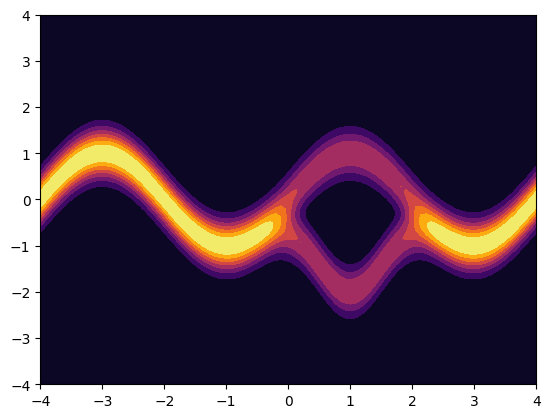

In [2]:
from src.densities import pot_3
target_density = pot_3

plot_pot_func(pot_3)

/Users/r8t/forked-normalizing-flows/.venv/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


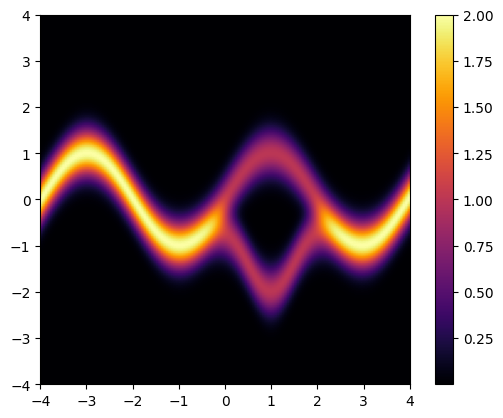

In [3]:

plot_2D_potential(pot_3)

In [21]:
# hyperparameters: 
n_flows = 16
batch_size = 100 
learning_rate = .001 
epochs = 15000

momentum = .9

----Plotting Gopi before----
----Plotting training----
Iteration 0
Loss 2.7898905277252197
Iteration 100
Loss 1.756988286972046
Iteration 200
Loss 1.0266797542572021
Iteration 300
Loss 0.5301156044006348
Iteration 400
Loss 0.786065936088562
Iteration 500
Loss 0.6273653507232666
Iteration 600
Loss 0.8709523677825928
Iteration 700
Loss 0.45391860604286194
Iteration 800
Loss 0.3821506202220917
Iteration 900
Loss 0.5193257927894592
Iteration 1000
Loss 0.4927578568458557
Iteration 1100
Loss 0.27108246088027954
Iteration 1200
Loss 0.3365510404109955
Iteration 1300
Loss 0.2725599706172943
Iteration 1400
Loss 0.06526350975036621
Iteration 1500
Loss 0.033216364681720734
Iteration 1600
Loss 0.27086082100868225
Iteration 1700
Loss 0.1680455505847931
Iteration 1800
Loss 0.10851842164993286
Iteration 1900
Loss 0.3295588791370392
Iteration 2000
Loss -0.21300454437732697
Iteration 2100
Loss -0.019249236211180687
Iteration 2200
Loss 0.0948866531252861
Iteration 2300
Loss 0.0875408723950386
Iteration 2

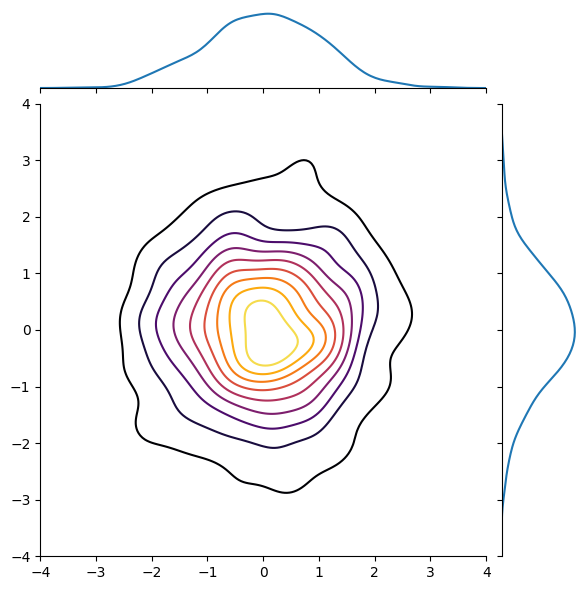

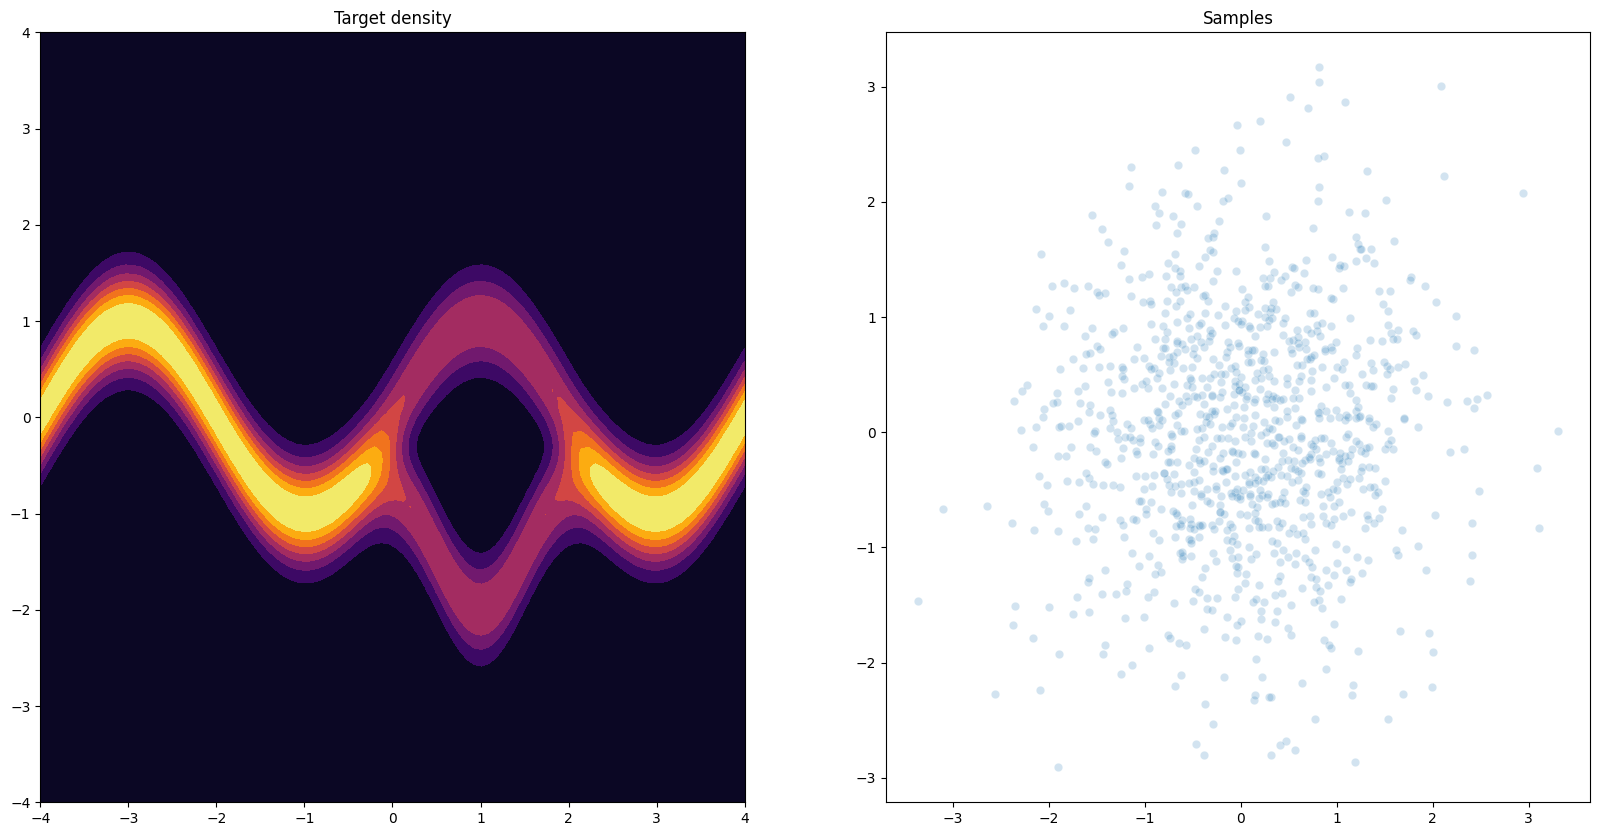

In [22]:
# train gopi

# instantiate new model: 
model = NormalizingFlow(2, n_flows=n_flows)

print("----Plotting Gopi before----")

# plot gopi output before: 
import seaborn as sns 
xsamples = prandom_normal_samples(1000, dim = 2)
zsamples = model.sample(( xsamples )).detach().numpy()

# kde map: 
cmap = plt.get_cmap('inferno')
p = sns.jointplot(x = zsamples[:, 0], y = zsamples[:, 1], kind='kde', cmap=cmap)
p.ax_marg_x.set_xlim(-4, 4)
p.ax_marg_y.set_ylim(-4, 4)

# density and samples
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes = axes.flat
plot_pot_func(target_density, axes[0])
axes[0].set_title('Target density')
sns.scatterplot(x = zsamples[:, 0], y = zsamples[:, 1], alpha=.2, ax=axes[1])
axes[1].set_title('Samples')

print("----Plotting training----")

## now train:RMSprop is what they used in renzende et al
opt = torch.optim.RMSprop(
    params=model.parameters(),
    lr=learning_rate,
    momentum=momentum
)

scheduler = ReduceLROnPlateau(opt, 'min', patience=1000)
losses = []

for iter_ in range(epochs):
    if iter_ % 100 == 0:
        print("Iteration {}".format(iter_))

    samples = prandom_normal_samples(batch_size, dim = 2)

    z_k, sum_log_det = model(samples)
    log_p_x = target_density(z_k)

    # Reverse KL since we can evaluate target density but can't sample
    loss = (- sum_log_det - (log_p_x)).mean()

    opt.zero_grad()
    loss.backward()
    opt.step()
    scheduler.step(loss)

    losses.append(loss.item())

    if iter_ % 100 == 0:
        print("Loss {}".format(loss.item()))



----Plotting Gopi after----


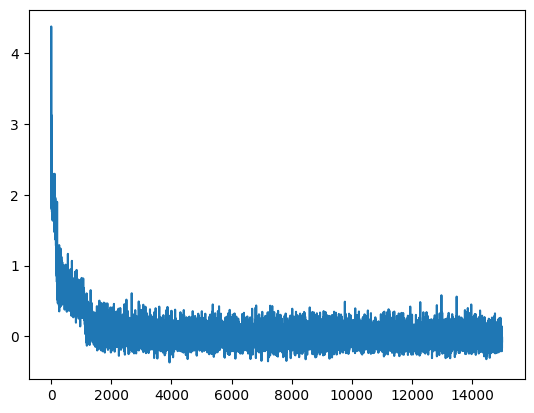

In [23]:
print("----Plotting Gopi after----")

# plot gopi losses 
plt.plot(losses)
plt.show()


(-4.0, 4.0)

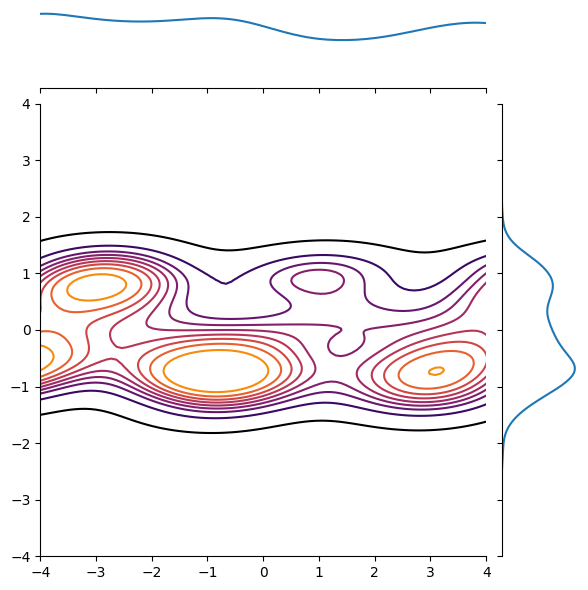

In [24]:


# plot gopi output after: 
xsamples = random_normal_samples(1000, dim = 2)
zsamples = model.sample(( xsamples )).detach().numpy()

# kde map: 
cmap = plt.get_cmap('inferno')
p = sns.jointplot(x = zsamples[:, 0], y = zsamples[:, 1], kind='kde', cmap=cmap)
p.ax_marg_x.set_xlim(-4, 4)
p.ax_marg_y.set_ylim(-4, 4)



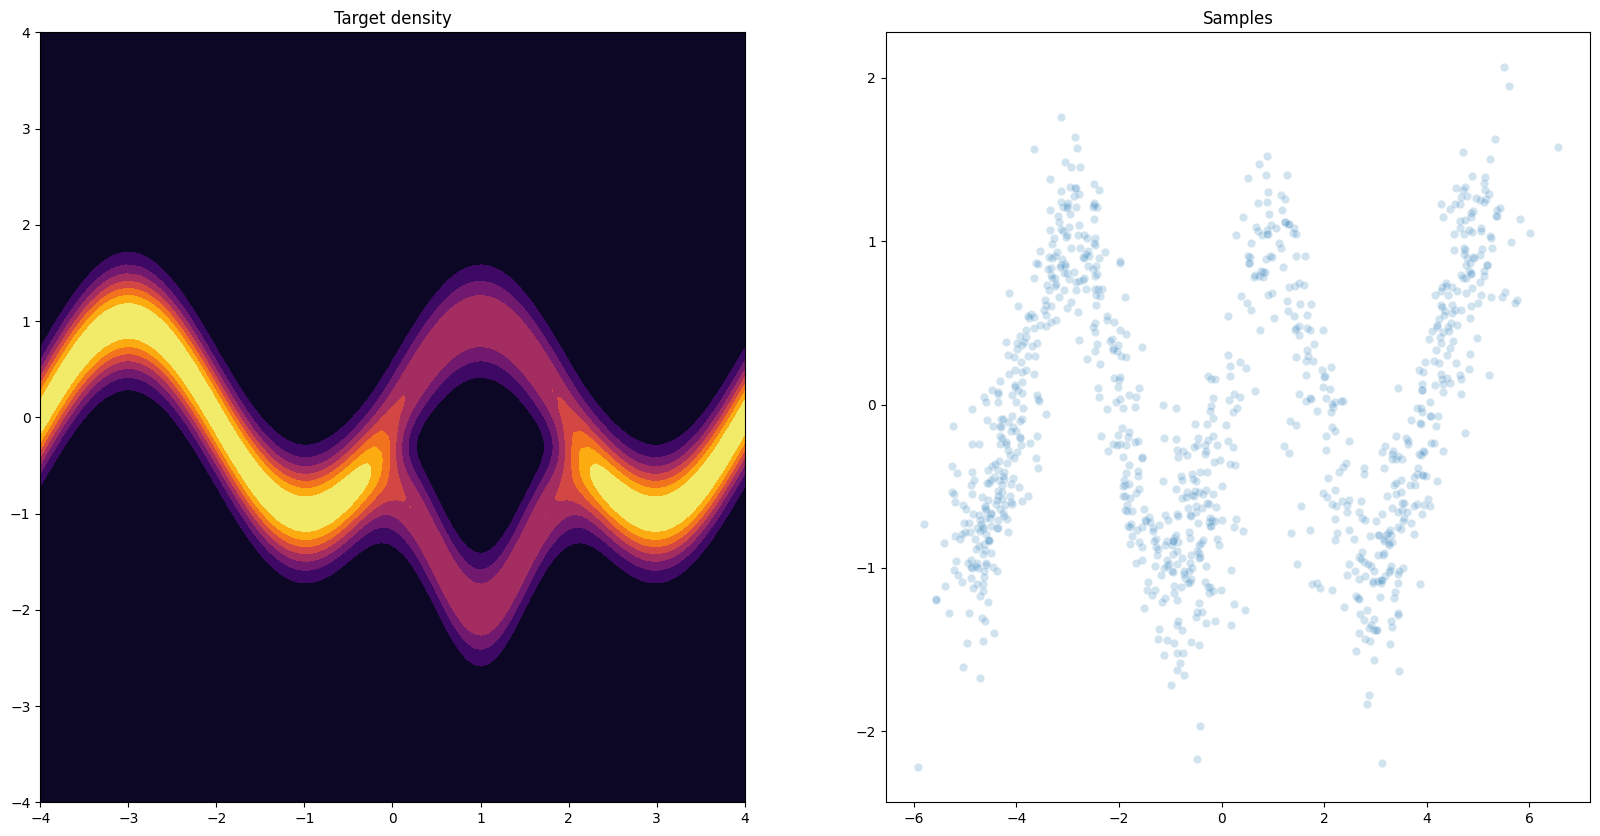

In [25]:

# density and samples
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes = axes.flat
plot_pot_func(target_density, axes[0])
axes[0].set_title('Target density')
sns.scatterplot(x = zsamples[:, 0], y = zsamples[:, 1], alpha=.2, ax=axes[1])
axes[1].set_title('Samples')
plt.show()


----Plotting PPO before----
----Plotting training----
Iteration 0
Loss 3.984637975692749
Iteration 100
Loss 0.7882016897201538
Iteration 200
Loss 0.2543216347694397
Iteration 300
Loss 0.23587992787361145
Iteration 400
Loss 0.3163837492465973
Iteration 500
Loss 0.3559724688529968
Iteration 600
Loss 0.4188162088394165
Iteration 700
Loss 0.467235803604126
Iteration 800
Loss 0.3404466211795807
Iteration 900
Loss 0.23181986808776855
Iteration 1000
Loss 0.1725555658340454
Iteration 1100
Loss -0.008296048268675804
Iteration 1200
Loss 0.47119149565696716
Iteration 1300
Loss 0.25833815336227417
Iteration 1400
Loss -0.03804532438516617
Iteration 1500
Loss 0.24903666973114014
Iteration 1600
Loss 0.26622018218040466
Iteration 1700
Loss -0.02400803565979004
Iteration 1800
Loss 0.05399082601070404
Iteration 1900
Loss 0.0911807119846344
Iteration 2000
Loss 0.18322934210300446
Iteration 2100
Loss 0.22264894843101501
Iteration 2200
Loss 0.25055891275405884
Iteration 2300
Loss -0.16051128506660461
Itera

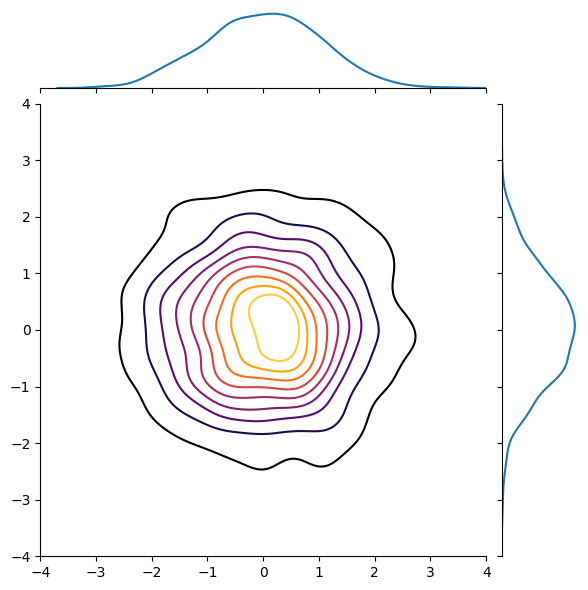

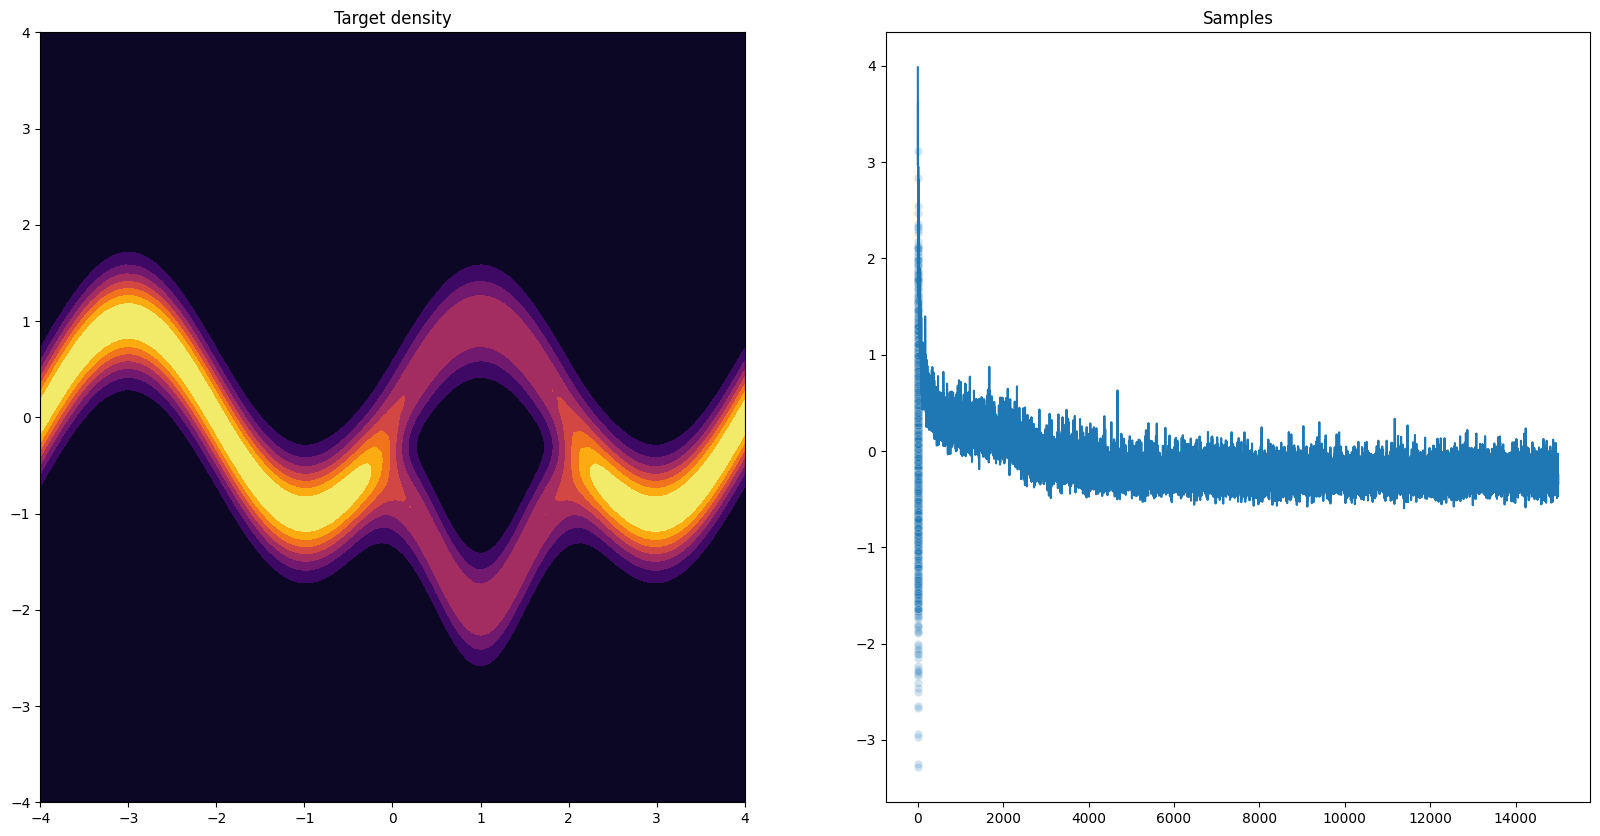

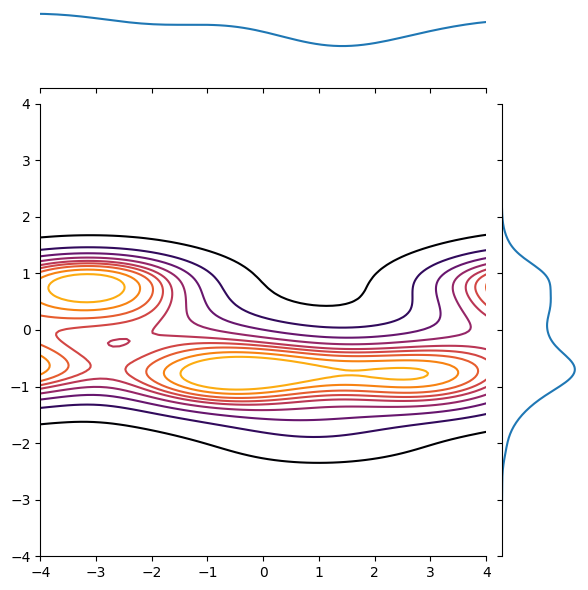

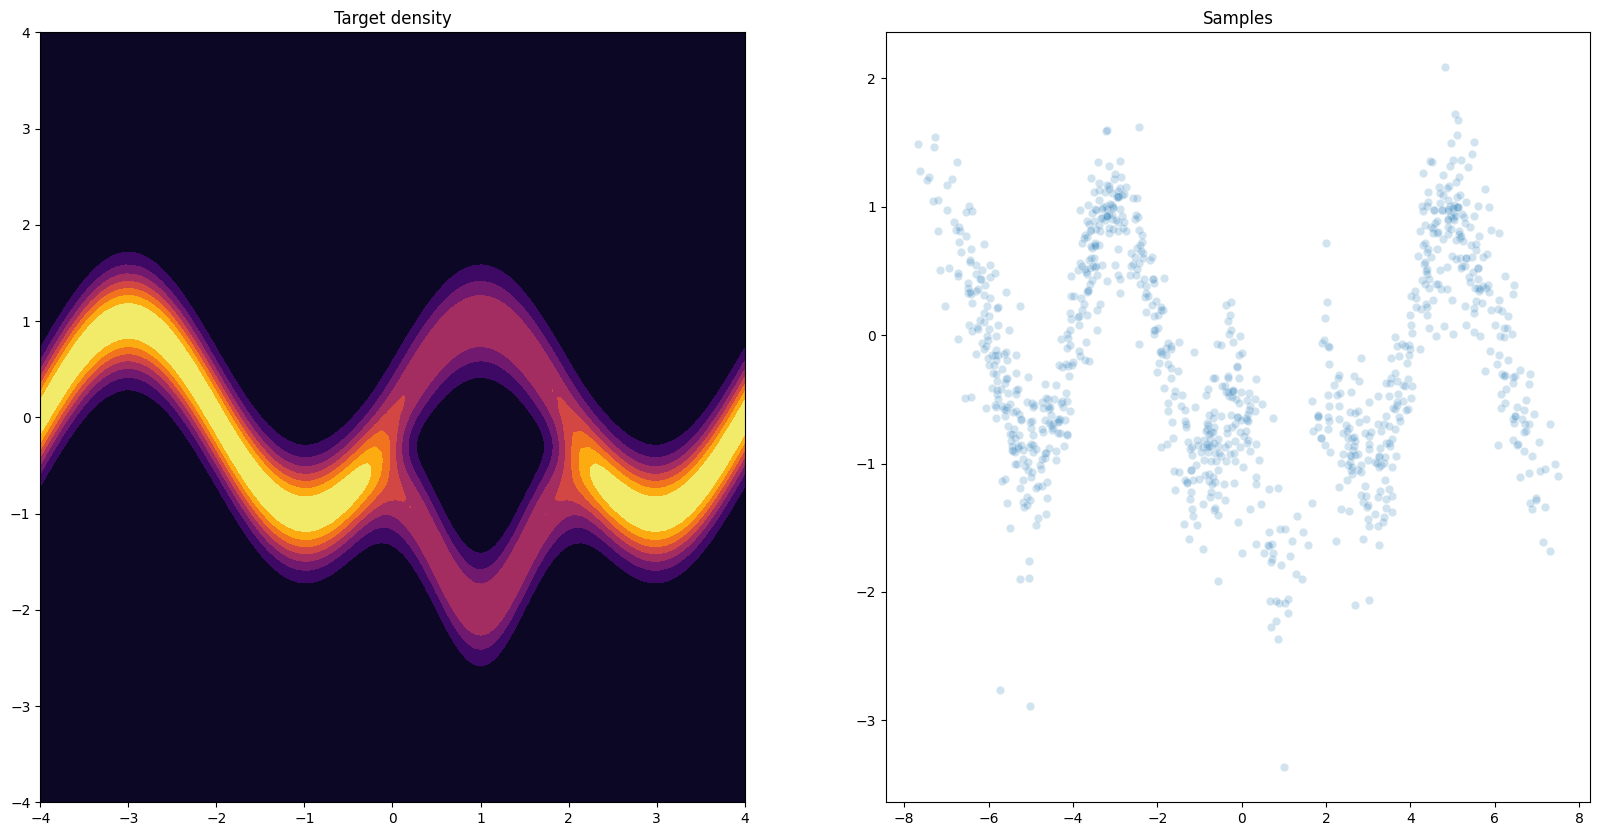

In [26]:
## try our model: 

# instantiate new model: 
model = ppoNormalizingFlow(2, n_flows=n_flows)

print("----Plotting PPO before----")

# plot gopi output before: 
import seaborn as sns 
xsamples = random_normal_samples(1000, dim = 2)
zsamples = model.sample(( xsamples )).detach().numpy()

# kde map: 
cmap = plt.get_cmap('inferno')
p = sns.jointplot(x = zsamples[:, 0], y = zsamples[:, 1], kind='kde', cmap=cmap)
p.ax_marg_x.set_xlim(-4, 4)
p.ax_marg_y.set_ylim(-4, 4)

# density and samples
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes = axes.flat
plot_pot_func(target_density, axes[0])
axes[0].set_title('Target density')
sns.scatterplot(x = zsamples[:, 0], y = zsamples[:, 1], alpha=.2, ax=axes[1])
axes[1].set_title('Samples')

print("----Plotting training----")

## now train:RMSprop is what they used in renzende et al
opt = torch.optim.RMSprop(
    params=model.parameters(),
    lr=learning_rate,
    momentum=momentum
)

scheduler = ReduceLROnPlateau(opt, 'min', patience=1000)
losses = []

for iter_ in range(epochs):
    if iter_ % 100 == 0:
        print("Iteration {}".format(iter_))

    samples = random_normal_samples(batch_size, dim = 2)

    z_k, sum_log_det = model(samples)
    log_p_x = target_density(z_k)

    # Reverse KL since we can evaluate target density but can't sample
    loss = (- sum_log_det - (log_p_x)).mean()

    opt.zero_grad()
    loss.backward()
    opt.step()
    scheduler.step(loss)

    losses.append(loss.item())

    if iter_ % 100 == 0:
        print("Loss {}".format(loss.item()))

print("----Plotting PPO after----")

# plot  losses 
plt.plot(losses)

# plot output after: 
xsamples = random_normal_samples(1000, dim = 2)
zsamples = model.sample(( xsamples )).detach().numpy()

# kde map: 
cmap = plt.get_cmap('inferno')
p = sns.jointplot(x = zsamples[:, 0], y = zsamples[:, 1], kind='kde', cmap=cmap)
p.ax_marg_x.set_xlim(-4, 4)
p.ax_marg_y.set_ylim(-4, 4)
plt.show() 

# density and samples
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes = axes.flat
plot_pot_func(target_density, axes[0])
axes[0].set_title('Target density')
sns.scatterplot(x = zsamples[:, 0], y = zsamples[:, 1], alpha=.2, ax=axes[1])
axes[1].set_title('Samples')
plt.show()


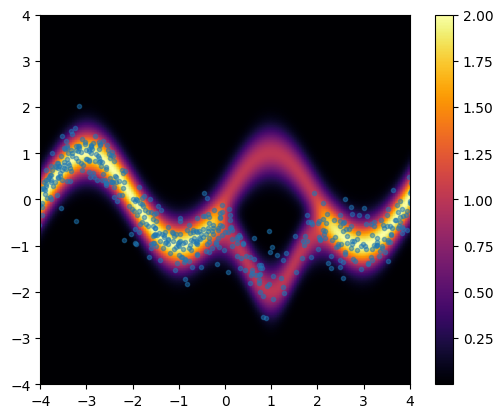

In [28]:
from ppo_code.plotting_utils import plot_2d_model_and_target
plot_2d_model_and_target(pot_3, model)


### Train and compare on potential 4

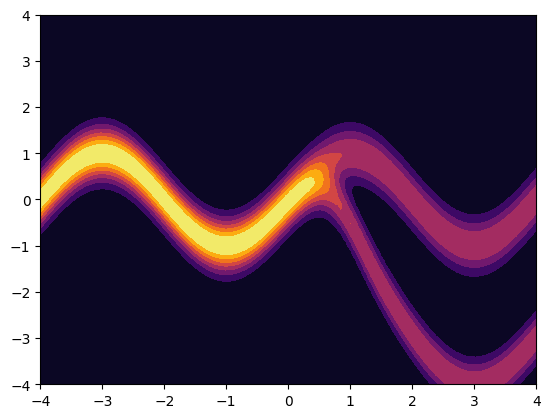

In [30]:
### Train and compare results on potential 4
from src.densities import pot_4
target_density = pot_4

plot_pot_func(pot_4)


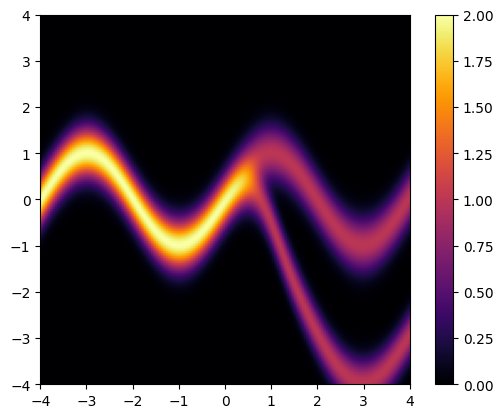

In [31]:

plot_2D_potential(pot_4)
# hyperparameters: 
n_flows = 16
batch_size = 200 
learning_rate = .001 
epochs = 12000

momentum = .9


----Plotting Gopi before----
----Plotting training----
Iteration 0
Loss 3.539994239807129
Iteration 100
Loss 0.8190731406211853
Iteration 200
Loss 0.6621566414833069
Iteration 300
Loss 0.39988410472869873
Iteration 400
Loss 0.5163850784301758
Iteration 500
Loss 0.5139967799186707
Iteration 600
Loss 0.41558393836021423
Iteration 700
Loss 0.4536806643009186
Iteration 800
Loss 0.32631105184555054
Iteration 900
Loss 0.17319780588150024
Iteration 1000
Loss 0.189241424202919
Iteration 1100
Loss 0.18884792923927307
Iteration 1200
Loss 0.06937737762928009
Iteration 1300
Loss 0.17706161737442017
Iteration 1400
Loss 0.1927504688501358
Iteration 1500
Loss 0.05811518430709839
Iteration 1600
Loss 0.11017033457756042
Iteration 1700
Loss 0.01120944693684578
Iteration 1800
Loss -0.015490490943193436
Iteration 1900
Loss 0.0036313270684331656
Iteration 2000
Loss 0.010310766287147999
Iteration 2100
Loss 0.036269109696149826
Iteration 2200
Loss -0.001725834677927196
Iteration 2300
Loss -0.1193400397896766

/var/folders/fy/kszc5b_n1dn3c5g8vg11ck4nvtb7xh/T/ipykernel_71584/1190822619.py:76: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.fig.show()


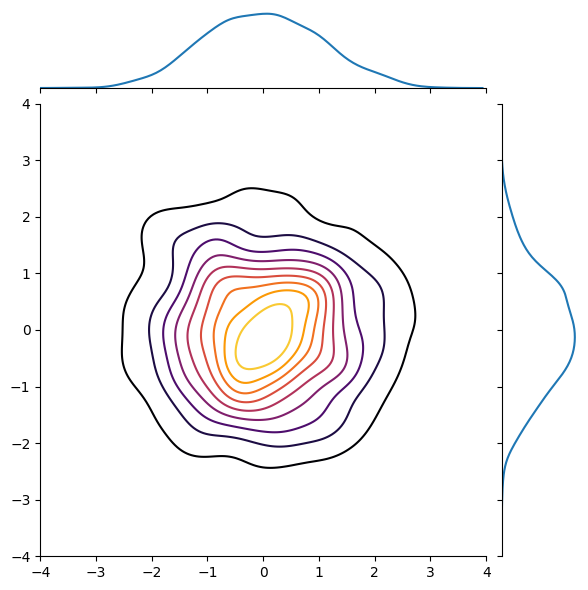

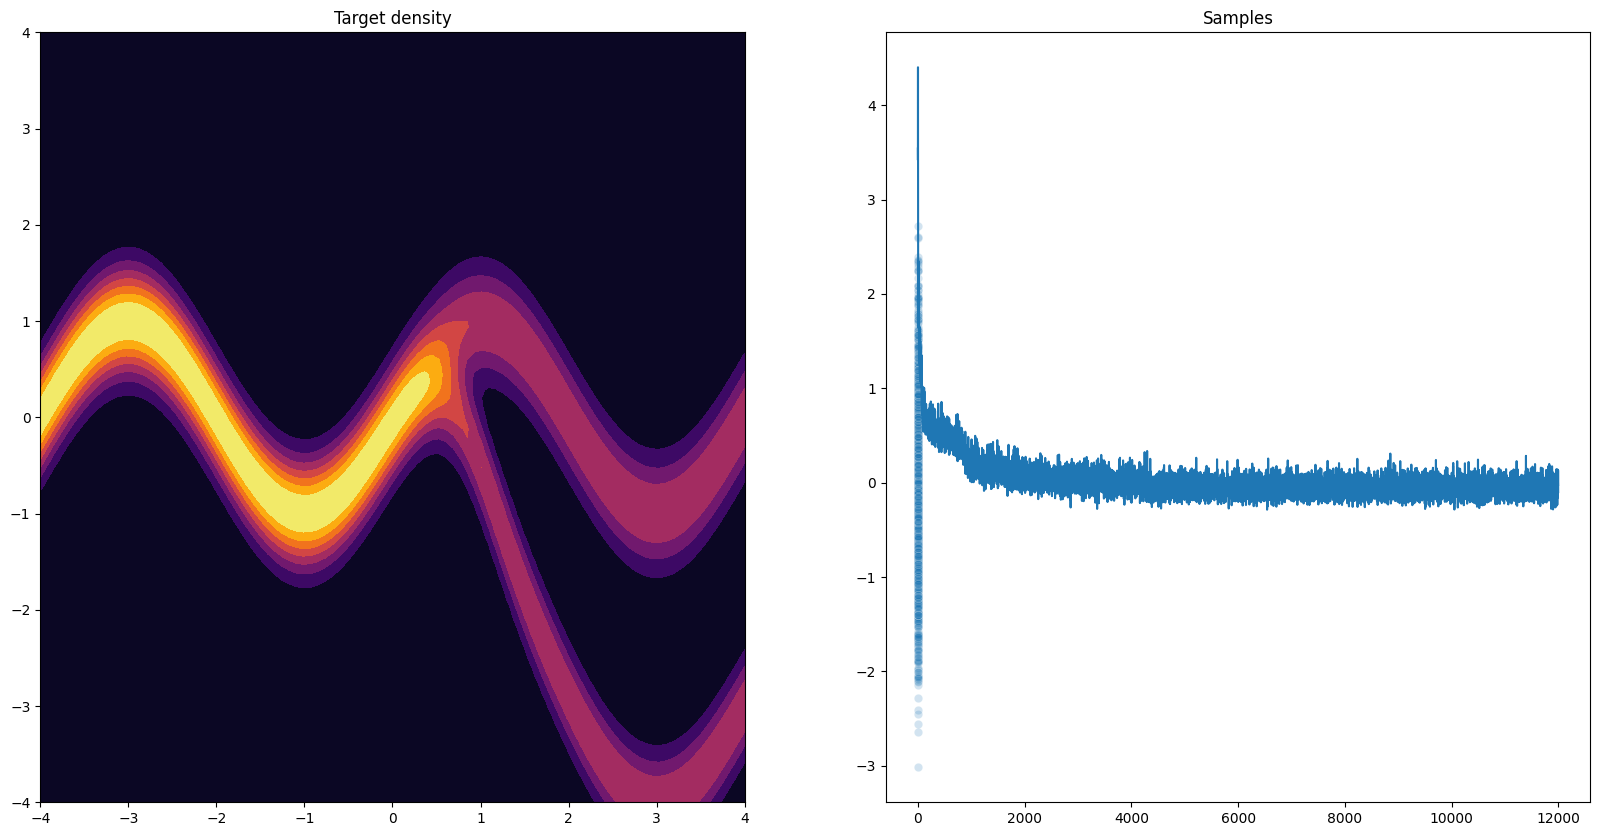

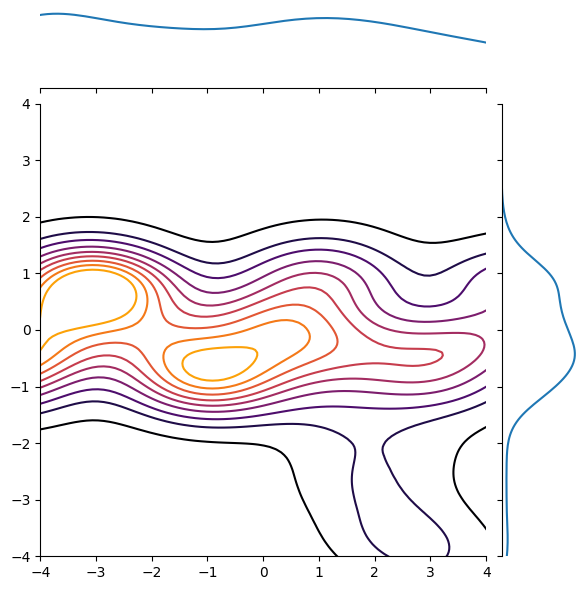

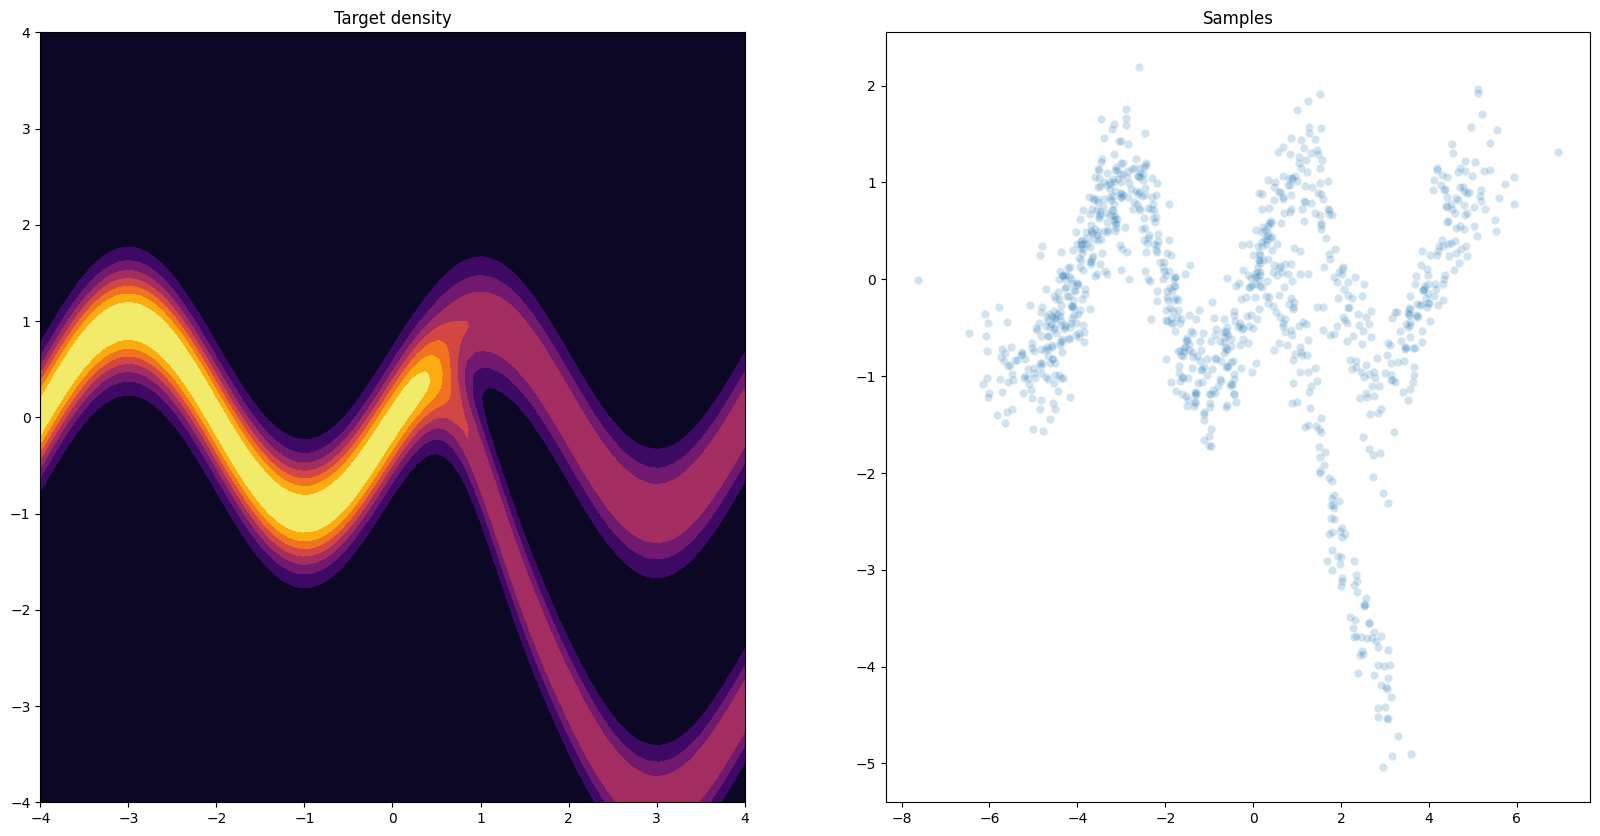

In [32]:

# train gopi

# instantiate new model: 
model = NormalizingFlow(2, n_flows=n_flows)

print("----Plotting Gopi before----")

# plot gopi output before: 
import seaborn as sns 
xsamples = prandom_normal_samples(1000, dim = 2)
zsamples = model.sample(( xsamples )).detach().numpy()

# kde map: 
cmap = plt.get_cmap('inferno')
p = sns.jointplot(x = zsamples[:, 0], y = zsamples[:, 1], kind='kde', cmap=cmap)
p.ax_marg_x.set_xlim(-4, 4)
p.ax_marg_y.set_ylim(-4, 4)

# density and samples
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes = axes.flat
plot_pot_func(target_density, axes[0])
axes[0].set_title('Target density')
sns.scatterplot(x = zsamples[:, 0], y = zsamples[:, 1], alpha=.2, ax=axes[1])
axes[1].set_title('Samples')

print("----Plotting training----")

## now train:RMSprop is what they used in renzende et al
opt = torch.optim.RMSprop(
    params=model.parameters(),
    lr=learning_rate,
    momentum=momentum
)

scheduler = ReduceLROnPlateau(opt, 'min', patience=1000)
losses = []

for iter_ in range(epochs):
    if iter_ % 100 == 0:
        print("Iteration {}".format(iter_))

    samples = prandom_normal_samples(batch_size, dim = 2)

    z_k, sum_log_det = model(samples)
    log_p_x = target_density(z_k)

    # Reverse KL since we can evaluate target density but can't sample
    loss = (- sum_log_det - (log_p_x)).mean()

    opt.zero_grad()
    loss.backward()
    opt.step()
    scheduler.step(loss)

    losses.append(loss.item())

    if iter_ % 100 == 0:
        print("Loss {}".format(loss.item()))

print("----Plotting Gopi after----")

# plot gopi losses 
plt.plot(losses)


# plot gopi output after: 
xsamples = prandom_normal_samples(1000, dim = 2)
zsamples = model.sample(( xsamples )).detach().numpy()

# kde map: 
cmap = plt.get_cmap('inferno')
p = sns.jointplot(x = zsamples[:, 0], y = zsamples[:, 1], kind='kde', cmap=cmap)
p.ax_marg_x.set_xlim(-4, 4)
p.ax_marg_y.set_ylim(-4, 4)
p.fig.show()

# density and samples
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes = axes.flat
plot_pot_func(target_density, axes[0])
axes[0].set_title('Target density')
sns.scatterplot(x = zsamples[:, 0], y = zsamples[:, 1], alpha=.2, ax=axes[1])
axes[1].set_title('Samples')
plt.show()



----Plotting PPO before----
----Plotting training----
Iteration 0
Loss 3.340207815170288
Iteration 100
Loss 1.0894081592559814
Iteration 200
Loss 0.6170970797538757
Iteration 300
Loss 0.7936350703239441
Iteration 400
Loss 0.4953266680240631
Iteration 500
Loss 0.5362651348114014
Iteration 600
Loss 0.3909536600112915
Iteration 700
Loss 0.4926338791847229
Iteration 800
Loss 0.3594117760658264
Iteration 900
Loss 0.4805043935775757
Iteration 1000
Loss 0.1866782009601593
Iteration 1100
Loss 0.16275456547737122
Iteration 1200
Loss 0.22561068832874298
Iteration 1300
Loss -0.050209105014801025
Iteration 1400
Loss 0.08400275558233261
Iteration 1500
Loss 0.07801216095685959
Iteration 1600
Loss -0.043191712349653244
Iteration 1700
Loss -0.03790522366762161
Iteration 1800
Loss -0.045053496956825256
Iteration 1900
Loss -0.2766907215118408
Iteration 2000
Loss 0.15430539846420288
Iteration 2100
Loss -0.043092407286167145
Iteration 2200
Loss -0.3426566421985626
Iteration 2300
Loss -0.016811538487672806

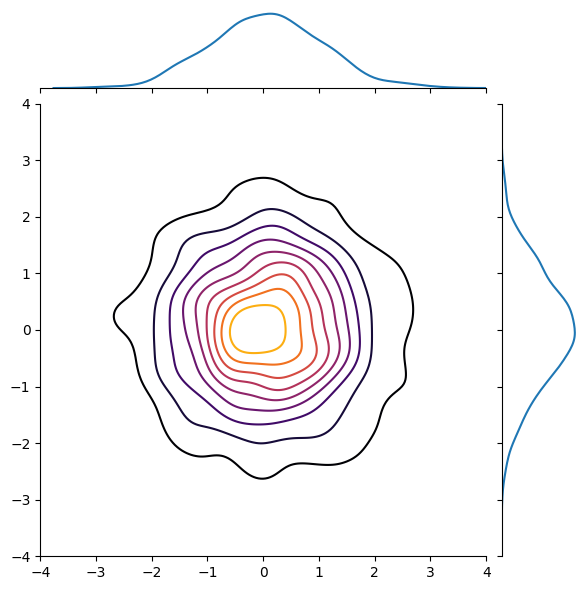

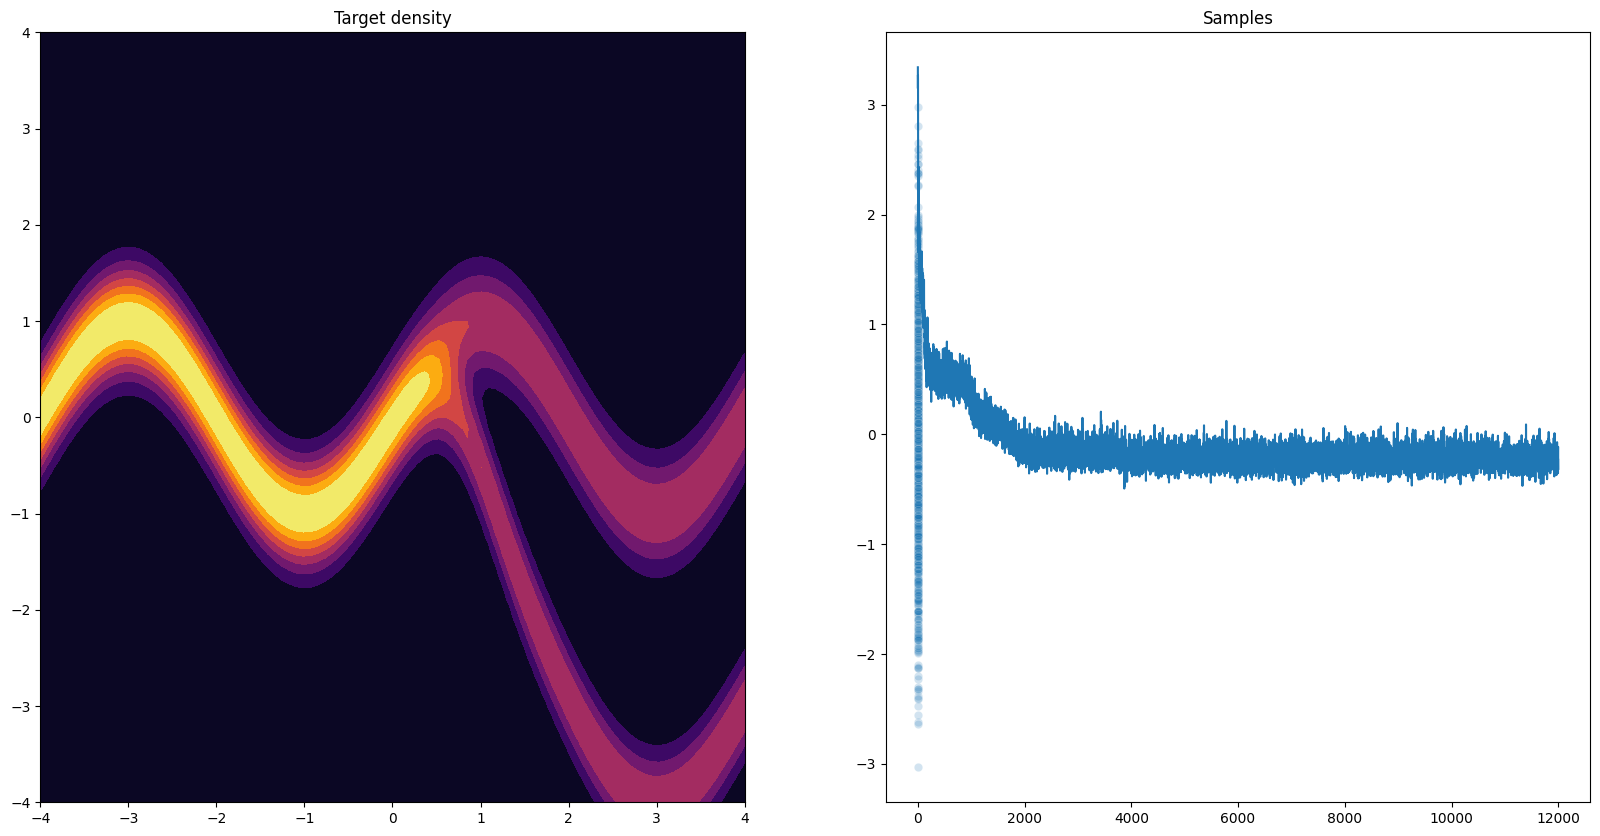

In [35]:

## try our model: 

# instantiate new model: 
model = ppoNormalizingFlow(2, n_flows=n_flows)

print("----Plotting PPO before----")

# plot gopi output before: 
import seaborn as sns 
xsamples = random_normal_samples(1000, dim = 2)
zsamples = model.sample(( xsamples )).detach().numpy()

# kde map: 
cmap = plt.get_cmap('inferno')
p = sns.jointplot(x = zsamples[:, 0], y = zsamples[:, 1], kind='kde', cmap=cmap)
p.ax_marg_x.set_xlim(-4, 4)
p.ax_marg_y.set_ylim(-4, 4)

# density and samples
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes = axes.flat
plot_pot_func(target_density, axes[0])
axes[0].set_title('Target density')
sns.scatterplot(x = zsamples[:, 0], y = zsamples[:, 1], alpha=.2, ax=axes[1])
axes[1].set_title('Samples')

print("----Plotting training----")

## now train:RMSprop is what they used in renzende et al
opt = torch.optim.RMSprop(
    params=model.parameters(),
    lr=learning_rate,
    momentum=momentum
)

scheduler = ReduceLROnPlateau(opt, 'min', patience=1000)
losses = []

for iter_ in range(epochs):
    if iter_ % 100 == 0:
        print("Iteration {}".format(iter_))

    samples = random_normal_samples(batch_size, dim = 2)

    z_k, sum_log_det = model(samples)
    log_p_x = target_density(z_k)

    # Reverse KL since we can evaluate target density but can't sample
    loss = (- sum_log_det - (log_p_x)).mean()

    opt.zero_grad()
    loss.backward()
    opt.step()
    scheduler.step(loss)

    losses.append(loss.item())

    if iter_ % 100 == 0:
        print("Loss {}".format(loss.item()))


# plot  losses 
plt.plot(losses)



----Plotting PPO after----


/var/folders/fy/kszc5b_n1dn3c5g8vg11ck4nvtb7xh/T/ipykernel_71584/926172430.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.figure.show()


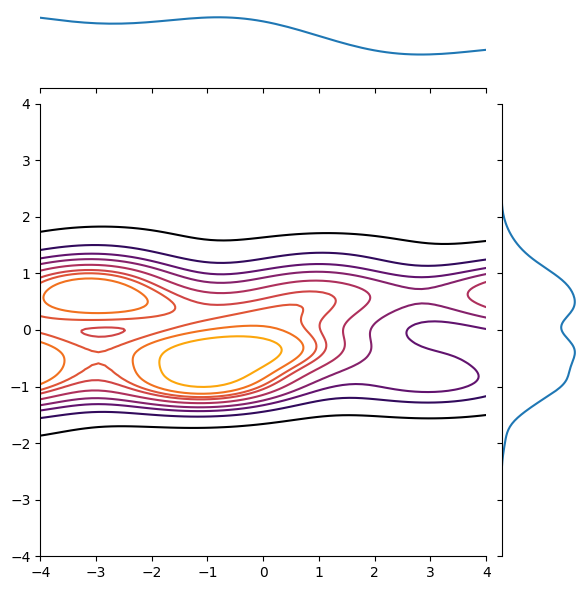

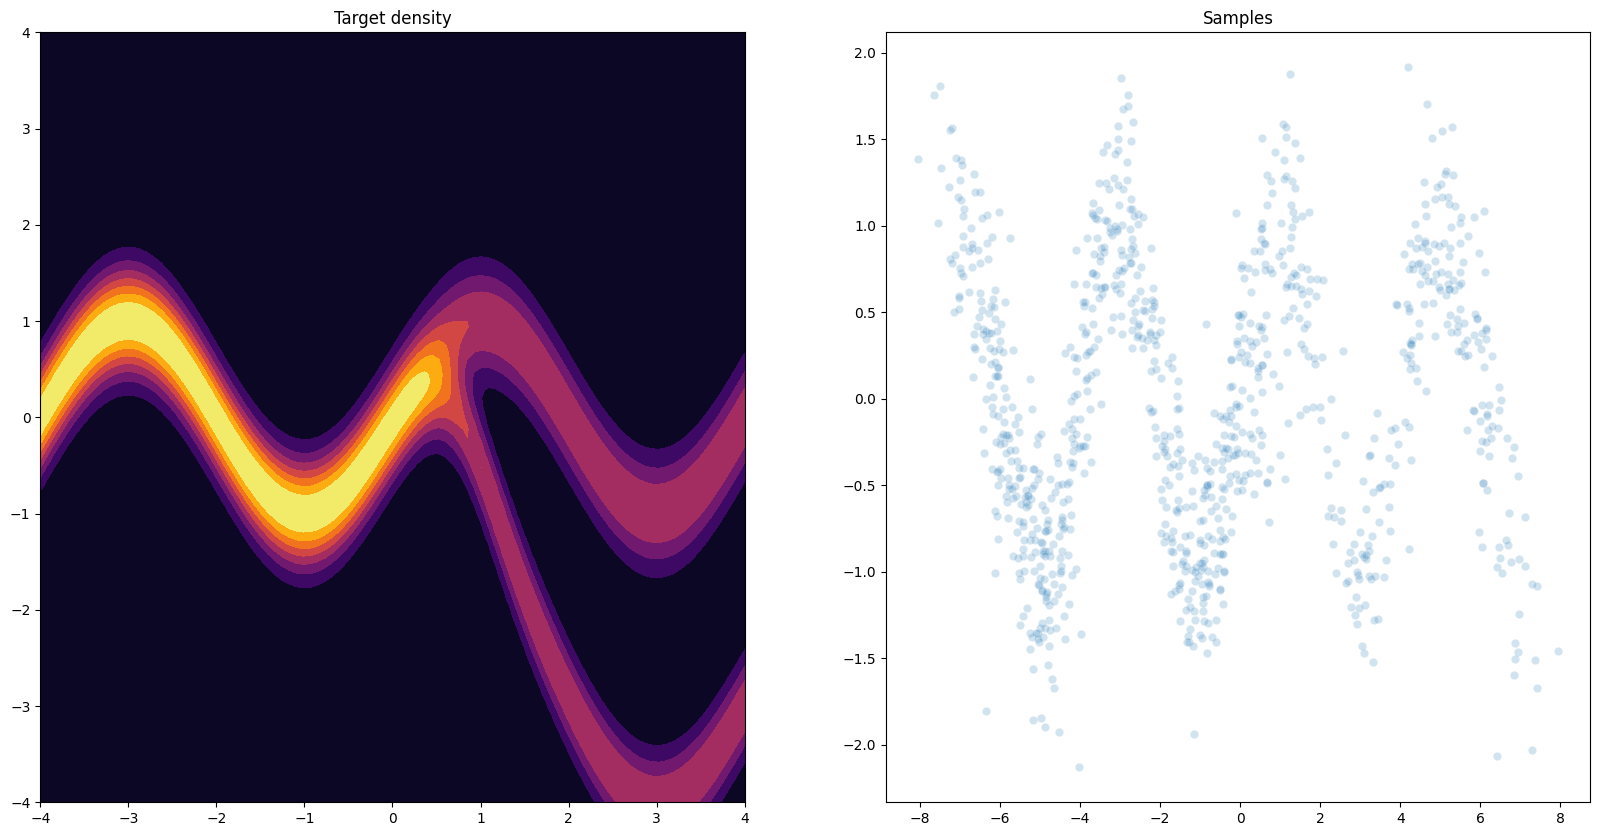

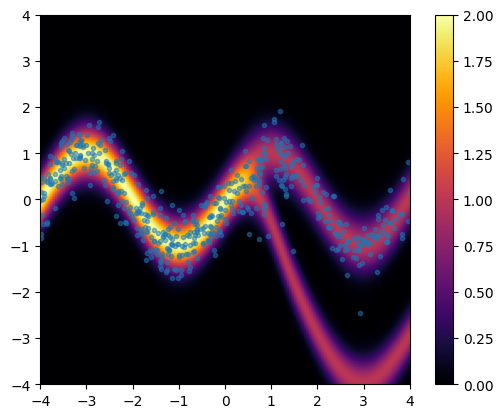

In [36]:

print("----Plotting PPO after----")

# plot output after: 
xsamples = random_normal_samples(1000, dim = 2)
zsamples = model.sample(( xsamples )).detach().numpy()

# kde map: 
cmap = plt.get_cmap('inferno')
p = sns.jointplot(x = zsamples[:, 0], y = zsamples[:, 1], kind='kde', cmap=cmap)
p.ax_marg_x.set_xlim(-4, 4)
p.ax_marg_y.set_ylim(-4, 4)
p.figure.show() 

# density and samples
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes = axes.flat
plot_pot_func(target_density, axes[0])
axes[0].set_title('Target density')
sns.scatterplot(x = zsamples[:, 0], y = zsamples[:, 1], alpha=.2, ax=axes[1])
axes[1].set_title('Samples')
plt.show()

# our plot 
plot_2d_model_and_target(target_density, model)
